In [1]:
import os
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer
from torch.utils.data import WeightedRandomSampler

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


## Data -- Generation

In [2]:
def generate_cards(attributes, attr_order, num_attributes, num_attr_vals):
    
    attr_order = attr_order[:num_attributes]
    attributes = {att_k:attributes[att_k][:num_attr_vals] for att_k in attributes if att_k in attr_order}
    
    cards = []
    idx_to_card = {}
    card_to_idx = {}

    i = 0
    attr_vals = [attributes[attr] for attr in attr_order]
    for combo in itertools.product(*attr_vals):
        card = tuple(combo)
        cards.append(card)
        card_to_idx[card] = i
        idx_to_card[i] = card
        i += 1
    
    assert len(cards) == len(set(cards))
    print(f'Generated {len(cards)} unqiue cards')                
    return cards, idx_to_card, card_to_idx


def num_shared_attributes(card1, card2):
    matching_concepts = tuple(s1 if s1==s2 else '-' for s1,s2 in zip(card1,card2))
    num_matching_concepts = len([c for c in matching_concepts if c != '-'])
    return matching_concepts, num_matching_concepts


def generate_card_pairs(cards, card_to_idx):
    '''
    find all combos of cards, filter down to the ones that share concepts.
    '''
    cardpairs_with_shared_concepts = []
    cardpairs_without_shared_concepts = []

    cardpair_to_idx, idx_to_cardpair, idx = {}, {}, 0
    num_matching_concepts_all = {}
    for card1, card2 in itertools.combinations(cards,2):
        if card1 != card2:
            matching_concepts, num_matching_concepts = num_shared_attributes(card1, card2)
            num_matching_concepts_all[(card1, card2)] = num_matching_concepts
            if num_matching_concepts:
                cardpairs_with_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            else:
                cardpairs_without_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            idx_to_cardpair[idx] = (card_to_idx[card1], card_to_idx[card2])
            cardpair_to_idx[(card_to_idx[card1], card_to_idx[card2])] = idx
            idx += 1
    print(f'Generated {len(cardpairs_with_shared_concepts) + len(cardpairs_without_shared_concepts)} cardpairs')
    print(f'-- {len(cardpairs_with_shared_concepts)} cardpairs with shared concept')
    print(f'-- {len(cardpairs_without_shared_concepts)} cardpairs without shared concept')
    print(Counter(num_matching_concepts_all.values()).most_common())
    return cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair


def match_concept_to_card(concept, card):
    '''
    Given a concept, determine if card matches.
    
    Arguments:
        concept: ('red', 'void', '-', '-')
        card: ex1. ('red', 'void', 'triangle', 'XOX')
              ex2. ('green', 'void', 'square', 'OXX')
    Returns:
        match: bool. ex1. True,
                     ex2. False
    '''
    match = 0
    for ct, cd in zip(concept, card):
        # As long as one concept matches, it is a match!
        if ct == cd:
            match += 1
    return match


def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

def gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=100, debug=False):
    
    # all cards
    cards, idx_to_card, card_to_idx = generate_cards(attributes, attr_order, num_attributes, num_attr_vals)
    # all card pairs
    cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = \
        generate_card_pairs(cards, card_to_idx)
    
    # generate answers
    all_matches = []
    number_of_shared_concepts_per_match = []
    cardpair_to_matches = defaultdict(lambda : defaultdict(int))
#     for cardpair in cardpairs_with_shared_concepts + cardpairs_without_shared_concepts: # NOTE!!
    for cardpair in cardpairs_with_shared_concepts:
        shared_concept = cardpair[1]
        # look for all matching cards
        # ((card pair query), matching card)
        for card in cards:
            num_matched_concepts = match_concept_to_card(shared_concept, card)
            if num_matched_concepts:
                all_matches.append((cardpair_to_idx[cardpair[0]], card_to_idx[card]))
                cardpair_to_matches[cardpair_to_idx[cardpair[0]]][card_to_idx[card]] = num_matched_concepts
                number_of_shared_concepts_per_match.append(num_matched_concepts)
    cardpair_to_matches = default_to_regular(cardpair_to_matches)
    print('Total number of matches = ', len(all_matches))
    print('Number of shared concepts per match = ', Counter(number_of_shared_concepts_per_match).most_common())
    
    # hold out some cardpairs
    unseen_cardpair_indices = list(np.random.choice(len(cardpair_to_idx), size=num_unseen_cardpairs, replace=False))
    train_cardpair_indices = [idx for idx in range(len(cardpair_to_idx)) if idx not in unseen_cardpair_indices]
    assert len(set(unseen_cardpair_indices) | set(train_cardpair_indices)) == len(cardpair_to_idx)
    
    data = {
        'idx_to_key': idx_to_card,
        'key_to_idx': card_to_idx,
        'query_to_idx': cardpair_to_idx, 
        'idx_to_query': idx_to_cardpair,
        'all_matches': all_matches, # list of tuples (query idx, answer card)
        'query_to_keys': cardpair_to_matches, # lookup query idx:{'card1':num matched concepts, 'card2':num matched concepts,...}
        'unseen_query_indices': unseen_cardpair_indices,
        'seen_query_indices': train_cardpair_indices
    }
    return data


attributes = {
    'color': ['red', 'green', 'blue', 'orange', 'cyan', 'magenta', 'black', 'yellow'],
    'fill': ['void', 'dashed', 'solid', 'checkered', 'dotted', 'mosaic', 'noise', 'brushed'],
    'shape': ['square', 'circle', 'triangle', 'star', 'hexagon', 'pentagon', 'ellipse', 'rectangle'],
    'config': ['OOO', 'OOX', 'OXO', 'OXX', 'XOO', 'XOX', 'XXO', 'XXX']
}

attr_order = ['color', 'fill', 'shape', 'config']

num_attributes = 2
num_attr_vals = 5
game_data = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)

Generated 25 unqiue cards
Generated 300 cardpairs
-- 100 cardpairs with shared concept
-- 200 cardpairs without shared concept
[(0, 200), (1, 100)]
Total number of matches =  500
Number of shared concepts per match =  [(1, 500)]


## Data -- Distribution, Splits

In [3]:
distribution_epsilon = 1e-100

count_table = np.zeros((len(game_data['idx_to_key']), len(game_data['idx_to_query'])))
        
for q, k in game_data['all_matches']:
    count_table[k, q] += 1    
        
xy = count_table/np.sum(count_table)
xy += distribution_epsilon
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

In [4]:
# + 0.1
[(0.0029940119760479044, 270), (0.003548458638278998, 54)]
# + nothing
Counter(list(xy.reshape(-1))).most_common()

[(1e-100, 7000), (0.002, 500)]

In [5]:
np.sum(count_table)

500.0

In [6]:
xy_rank = np.linalg.matrix_rank(xy)
print('xy_rank=',xy_rank)

xy_div_xyind_rank = np.linalg.matrix_rank((xy/xyind))
print('xy_div_xyind_rank=',xy_div_xyind_rank)

xy_rank= 9
xy_div_xyind_rank= 9


In [7]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
figrange = (0, len(game_data['idx_to_key']), 0, len(game_data['idx_to_query']))

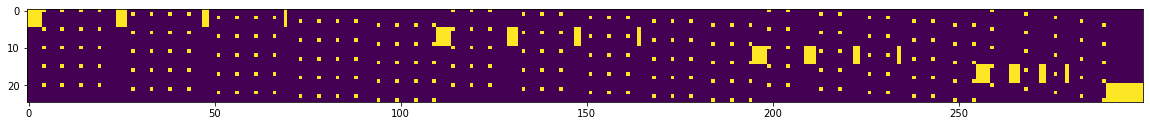

In [8]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

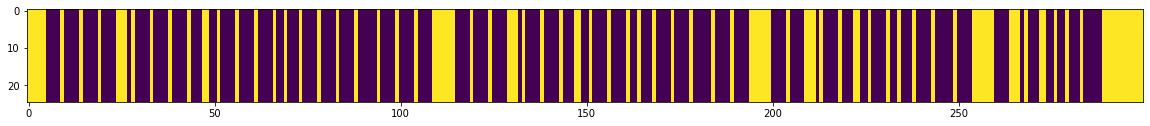

In [9]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

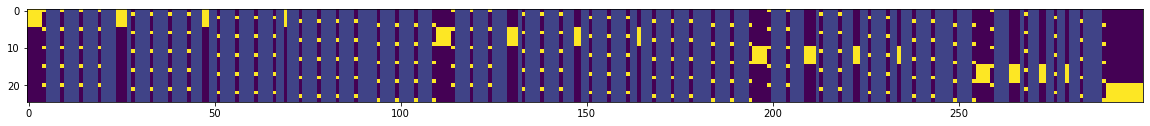

In [10]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

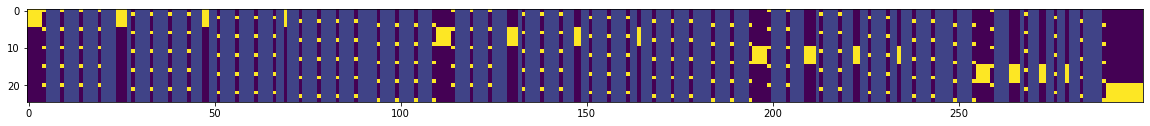

In [11]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [12]:
Counter(list((xy/xyind).reshape(-1))).most_common()

[(0.9999999999999997, 3800),
 (2.5e-97, 1920),
 (0.9999999999999993, 1000),
 (5.0, 380),
 (0.9999999999999998, 200),
 (4.999999999999999, 100),
 (2.5000000000000003e-97, 80),
 (5.000000000000001, 20)]

## Dataset

In [13]:
### One embed per query!

class GameDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return self.query_support_size * self.key_support_size
    
    def __getitem__(self, idx):
        '''
        key_idx: (xy_i) * (xy.shape[1]=self.query_support_size) + (xy_j)
        '''
        x_i, y_j = idx//self.query_support_size, idx%self.query_support_size
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0
        
        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('key\n', x_i, self.raw_data['idx_to_key'][x_i])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )    

game_dataset = GameDataset(raw_data=game_data, debug=True)
game_dataset[10] 
print('-----')
game_dataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void') ('blue', 'dashed')
key
 0 ('red', 'void')
all matches 
 []
-----
query
 7 : 0 8 ('red', 'void') ('green', 'checkered')
key
 0 ('red', 'void')
all matches 
 []


(7,
 tensor([7]),
 tensor([0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]))

In [14]:
class GameTestFullDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        queries_with_shared_attr_only: bool.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return len(self.raw_data['idx_to_query'])
    
    def __getitem__(self, idx):
        '''
        key_idx: int. 0 to query_support_size-1
        '''
        y_j = idx
        x_i = torch.empty(1) # just a meaningless value
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0

        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
            
            
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        ) 
    
game_testdataset = GameTestFullDataset(raw_data=game_data, debug=True)
game_testdataset[10]
print('-----')
game_testdataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void') ('blue', 'dashed')
all matches 
 []
-----
query
 7 : 0 8 ('red', 'void') ('green', 'checkered')
all matches 
 []


(7,
 tensor([7]),
 tensor([0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]))

In [15]:
class GameDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size, raw_data, seen_train_xy, seen_val_xy, debug=False):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = GameDataset(raw_data=raw_data, debug=debug)
#         self.testdataset = GameTestFullDataset(raw_data=raw_data, debug=debug)
        self.seen_train_xy = seen_train_xy
        self.seen_val_xy = seen_val_xy
        self.setup_samplers()
        
    def setup_samplers(self):
        self.train_sampler = WeightedRandomSampler(
            weights=self.seen_train_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        ) 
        self.val_sampler = WeightedRandomSampler(
            weights=self.seen_val_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        )
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train = self.dataset
            self.val = self.dataset
#         if stage == 'test' or stage is None:
#             self.test = self.testdataset
            
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train, batch_size=self.batch_size, shuffle=False, sampler=self.train_sampler
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val, batch_size=self.batch_size,  shuffle=False, sampler=self.val_sampler
        )
        return val_loader
    
#     def test_dataloader(self):
#         test_loader = DataLoader(
#             self.test, batch_size=self.batch_size, shuffle=False
#         )
#         return test_loader  

## Model Architecture

In [16]:
def construct_full_model(hparams):
    '''
    return: nn.Module.
    '''
    # embeddings
    query_embed_X = ScaledEmbedding(hparams['query_support_size'], hparams['d_model'])
    key_embed_X = ScaledEmbedding(hparams['key_support_size'], hparams['d_model'])
    embed_dropout = nn.Dropout(hparams['embed_dropout'])
    
    # classifier
    if hparams['classifier_nonlinearity'] == 'ReLU':
        classifier_non_linearity = nn.ReLU
    elif hparams['classifier_nonlinearity'] == 'Sigmoid':
        classifier_non_linearity = nn.Sigmoid
    else:
        raise ValueError('Unaccepted choice of nonlinearity')
    
    # full model
    model = EncoderPredictor(
        inp_query_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', query_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        inp_key_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', key_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        classifier = nn.Sequential(
            OrderedDict(
                make_classifier(
                    scale_down_factor=hparams['classifier_layer_scaledown_factor'], 
                    d_model=hparams['d_model'],
                    non_linearity_class = classifier_non_linearity,
                )
            )
        ) if not hparams['dotproduct_bottleneck'] else None, 
        key_support_size = hparams['key_support_size'],
        d_model = hparams['d_model'],
        debug = hparams['debug'],
    )
    
    return model

In [17]:
def make_classifier(scale_down_factor, d_model, non_linearity_class):
    '''
    scale_down_factor: list e.g. [2,2,4]
    '''
    layer_lst = []
    last_dim = 2*d_model
    for i in range(len(scale_down_factor)):
        new_dim = int(2*d_model / scale_down_factor[i])
        layer_lst.append(('linear{}'.format(i), nn.Linear(last_dim, new_dim)))
        layer_lst.append(('Nonlinear{}'.format(i), non_linearity_class()))
        last_dim = new_dim
    layer_lst.append(('linear-out', nn.Linear(last_dim, 1)))
    
    return layer_lst

make_classifier([2,2,4], 48, nn.ReLU)

[('linear0', Linear(in_features=96, out_features=48, bias=True)),
 ('Nonlinear0', ReLU()),
 ('linear1', Linear(in_features=48, out_features=48, bias=True)),
 ('Nonlinear1', ReLU()),
 ('linear2', Linear(in_features=48, out_features=24, bias=True)),
 ('Nonlinear2', ReLU()),
 ('linear-out', Linear(in_features=24, out_features=1, bias=True))]

In [18]:
class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded

In [19]:
class EncoderPredictor(nn.Module):
    
    def __init__(self, inp_query_layer, inp_key_layer, classifier, key_support_size, d_model, debug=False):
        super().__init__()
        self.inp_query_layer = inp_query_layer
        self.inp_key_layer = inp_key_layer
        self.classifier = classifier
        print(classifier)
        self.key_support_size = key_support_size
        self.d_model = d_model
        
    def forward(self, X_query, X_key, val_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1) if test bool, else (b, num matched cards) or None.
        '''
        if X_key is not None: assert X_query.shape == X_key.shape
        if val_bool:
            return self.forward_norm_support(X_query, debug=debug)
        else:
            assert X_key is not None, 'X_key should not be None for normalizing over minibatch keys.'
            return self.forward_norm_minibatch(X_query, X_key, debug=debug)

    def forward_norm_minibatch(self, X_query, X_key, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)
        
        # shape(b, d_model)
        key_repr = self.encode_key(X_key).squeeze(1)
        assert key_repr.shape == (b, self.d_model)

        if self.classifier:
            # shape(b, b, d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, b, self.d_model)
            # shape(b, b, d_model)
            key_repr_tiled = key_repr.unsqueeze(0).expand(b, b, self.d_model)
            # shape(b, b, 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            assert query_key_concat.shape == (b, b, 2*self.d_model)
            # shape(b*b, 2*d_model)
            query_key_concat = query_key_concat.reshape(b*b, 2*self.d_model)
            # shape(b*b, 1)
            logits = self.classifier(query_key_concat)
            assert logits.shape == (b*b, 1)
            # shape(b, b)
            logits = logits.squeeze(1).reshape(b, b)
        else:
            # shape(b, b) dotproduct=logit matrix
            logits = torch.matmul(query_repr, key_repr.T)
        assert logits.shape == (b, b)
        
        # shape(b, b)
        return logits

    def forward_norm_support(self, X_query, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)

        # shape(size(support), d_model)
        keys_repr = self.encode_all_keys()
        assert keys_repr.shape == (self.key_support_size, self.d_model)
        
        if self.classifier:
            # shape(b, size(support), d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), d_model)
            key_repr_tiled = keys_repr.unsqueeze(0).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            # shape(b*size(support), 2*d_model)
            query_key_concat = query_key_concat.reshape(b*self.key_support_size, 2*self.d_model)
            # shape(b*size(support), 1)
            logits = self.classifier(query_key_concat)
            # shape(b, size(support))
            logits = logits.squeeze(1).reshape(b, self.key_support_size)
        else:
            # shape(b, size(support)) dotproduct=logit matrix
            logits = torch.matmul(query_repr, keys_repr.T)
        assert logits.shape == (b, self.key_support_size)
        
        # shape(b, size(support)) 
        return logits

    def encode_query(self, X):
        '''
        X: (batch_size=b,1)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_query_layer(X)
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed     
        
    def encode_key(self, X):
        '''
        X: (batch_size=b)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_key_layer(X) 
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed  

    def encode_all_keys(self):
        
        # shape(size(support), embed_dim)
        all_embed = self.inp_key_layer.scaled_embed.embedding.weight
        assert all_embed.requires_grad == True
        assert all_embed.shape == (self.key_support_size, self.d_model)
        
        return all_embed

## Loss, Metric

In [20]:
class InfoCELoss(nn.Module):
    '''
    InfoCE Loss on a (b, b) logits matrix with Temperature scaling
    '''

    def __init__(self, temperature_const=1.0):
        super().__init__()
        self.temperature_const = temperature_const
        self.CE_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, logits, debug=False):
        '''
        logits: shape (batch_size=b, b)
        '''
        assert logits.shape[0] == logits.shape[1]
        b = logits.shape[0]
        
        logits /= self.temperature_const
        
        labels = torch.arange(b).type_as(logits).long()
        sum_loss_per_row = self.CE_loss(logits, labels)
        sum_loss_per_col = self.CE_loss(logits.T, labels)
        
        if debug:
            print('sum_loss_per_row=',sum_loss_per_row)
            print('sum_loss_per_col=',sum_loss_per_col)

        loss = (sum_loss_per_row + sum_loss_per_col) * 0.5
        return loss


# ---------------------------    
loss_criterion = InfoCELoss(temperature_const=0.1)

logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))
print('-------------')
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))


# ref
# sum_loss_per_row= tensor(20.0001)
# sum_loss_per_col= tensor(60.0001)
# avg loss= tensor(40.0001)
# -------------
# sum_loss_per_row= tensor(0.6933)
# sum_loss_per_col= tensor(40.0001)
# avg loss= tensor(20.3467)

sum_loss_per_row= tensor(20.0001)
sum_loss_per_col= tensor(60.0001)
avg loss= tensor(40.0001)
-------------
sum_loss_per_row= tensor(0.6933)
sum_loss_per_col= tensor(40.0001)
avg loss= tensor(20.3467)


In [21]:
class ThresholdedMetrics(nn.Module):
    
    def __init__(self, raw_data):
        '''
        tot_k: total number of candidates. e.g. 81 cards
        '''
        super().__init__()
        self.raw_data = raw_data
        self.key_support_size = len(self.raw_data['idx_to_key'])
        self.threshold = 1.0 / (self.key_support_size)
        self.softmax = nn.Softmax(dim=1)

    def breakdown_errors(self, X_query, corrects):
        '''
        X_query: shape (b,1) (if one embed per query)
        corrects: shape (b, support size)
        '''
        b = X_query.shape[0]
        assert corrects.shape == (b, self.key_support_size)
        
        X_query_list = X_query.squeeze(-1)
        wrongs = (1 - corrects).cpu().numpy()
        
        num_matched_concepts = [
             self.raw_data['query_to_keys'].get(X_query_list[batch_i].item(), {}).get(card_idx, 0)
            for batch_i in range(b) for card_idx in range(self.key_support_size)  
        ]
        
        num_matched_concepts = np.array(num_matched_concepts).reshape(b, self.key_support_size)
        assert num_matched_concepts.shape == wrongs.shape
        
        wrongs_mask = wrongs.reshape(-1).tolist()
        num_matched_concepts = num_matched_concepts.reshape(-1).tolist()

        error_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        total_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        for w,k in zip(wrongs_mask, num_matched_concepts):
            if w == 1:
                error_count_by_num_matched_concepts[k] += 1
            total_count_by_num_matched_concepts[k] += 1    

        error_counts, total_counts = {}, {}
        for k in range(num_attributes):
            err_ct = error_count_by_num_matched_concepts[k]
            tot_ct = total_count_by_num_matched_concepts[k]
            error_counts[f'error_rate_for_{k}_matched_concepts'] = 0 if tot_ct == 0 else (err_ct *1.0 / tot_ct)
            total_counts[f'total_count_for_{k}_matched_concepts'] = tot_ct

        return {**error_counts, **total_counts}    
    
    def forward(self, X_query, logits, X_keys, full_test_bool=False, breakdown_errors_bool=False, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        b, key_support_size = logits.shape
        assert key_support_size == self.key_support_size
        assert logits.shape == X_keys.shape
        
        if full_test_bool:
            # filter down to query cards with >0 true matches
            queryIdxs_with_nonzero_matches = list(self.raw_data['query_to_keys'].keys())
            X_query_flat = X_query.squeeze(-1)
            fil = torch.stack([(X_query_flat == qId) for qId in queryIdxs_with_nonzero_matches], dim=1).any(dim=1)
            assert fil.shape == (b, )
            
            # queries with shared attributes
            fil_metrics = self.compute_metrics(X_query[fil], logits[fil], X_keys[fil], breakdown_errors_bool, debug)
            fil_metrics = {'nonNullQueries_'+k:fil_metrics[k] for k in fil_metrics}
            
            # queries without shared attributes
            not_fil = torch.logical_not(fil)
            not_fil_metrics = self.compute_metrics(X_query[not_fil], logits[not_fil], X_keys[not_fil], breakdown_errors_bool, debug)
            not_fil_metrics = {'NullQueries_'+k:not_fil_metrics[k] for k in not_fil_metrics}
            
            # all queries
            all_metrics = self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
            
            return {**fil_metrics, **not_fil_metrics, **all_metrics}
        else:
            return self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
    
    def compute_metrics(self, X_query, logits, X_keys, breakdown_errors_bool=False, debug=False):
        '''
        X_query: shape (b,1) (if one embed per query)
        logits: shape (b, support size)
        X_keys: shape (b, support size). value 1.0 at where card matches. value 0 otherwise.
        '''
        b, key_support_size = logits.shape
        
        # model predictions, shape (b, support size)
        binary_predictions = (self.softmax(logits) >= self.threshold).type(torch.float)
        # ground truth, shape (b, support size)
        gt = X_keys
        # correct predictions, shape (b, support size)
        corrects = (binary_predictions == gt).type(torch.float)
        
        # accuracy, computed per query, average across queries
        # (b,)
        accuracy_row = torch.sum(corrects, dim=1) / key_support_size
        # scalar
        accuracy_meanrows = torch.mean(accuracy_row)
        # accuracy, computed per query-key, average across all
        accuracy_all = torch.sum(corrects) / (b * key_support_size)
        
        # precision, computed per query, average across queries
        # (b,)
        precision_row = torch.sum((corrects * binary_predictions), dim=1) / torch.sum(binary_predictions, dim=1)
        # scalar
        precision_meanrows = torch.mean(precision_row)
        # precision, computed per query-key, average across all
        precision_all = torch.sum((corrects * binary_predictions)) / torch.sum(binary_predictions)

        # recall, computed per query, average across queries
        # (b,)
        recall_row = torch.sum((corrects * gt), dim=1) / torch.sum(gt, dim=1)
        # scalar
        recall_meanrows = torch.mean(recall_row)
        # recall, computed per query-key, average across all
        recall_all = torch.sum((corrects * gt)) / torch.sum(gt)
        
        # f1, computed per query, average across queries
        # (b,)
        f1_row = 2 * (precision_row * recall_row) / (precision_row + recall_row)
        # scalar
        f1_meanrows = torch.mean(f1_row)
        # f1, computed per query-key, average across all
        f1_all = (precision_all * recall_all) / (precision_all + recall_all)
        
        if breakdown_errors_bool:
            error_breakdown_by_num_matched_concepts = self.breakdown_errors(X_query, corrects)
        else:
            error_breakdown_by_num_matched_concepts = {} 
            
        if debug:
            print('####################################################')
            print('Metrics Per Query:')
            print('accuracy_rows', accuracy_row)
            print('precision_row', precision_row)
            print('recall_row', recall_row)
            print('f1_row', f1_row)
            print('####################################################')
            print('Metrics Averaged Across Queries')
            print('accuracy_meanrows', accuracy_meanrows)
            print('precision_meanrows', precision_meanrows)
            print('recall_meanrows', recall_meanrows)
            print('f1_meanrows', f1_meanrows)
            print('####################################################')
            print('Metrics Averaged Across All Query-Key Pairs:')
            print('accuracy_all', accuracy_all)
            print('precision_all', precision_all)
            print('recall_all', recall_all)
            print('f1_all', f1_all)
            print('####################################################')
            print('error_breakdown', error_breakdown_by_num_matched_concepts)
            
        metrics = {
            'accuracy_by_Query': accuracy_meanrows,
            'precision_by_Query': precision_meanrows,
            'recall_by_Query': recall_meanrows,
            'f1_by_Query': f1_meanrows,
            'accuracy_by_QueryKey': accuracy_all,
            'precision_by_QueryKey': precision_all,
            'recall_by_QueryKey': recall_all,
            'f1_by_QueryKey': f1_all
        }
        metrics = {
            **metrics, **error_breakdown_by_num_matched_concepts
        }
        return metrics


def test_metric_module():
    key_support_size=3
    thresh=1./key_support_size

    m_f = ThresholdedMetrics(raw_data=game_data)
    m_f.key_support_size = 3

    logits = torch.tensor(
        [
            [thresh, thresh, thresh],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    print('----------------------------------------------')
    
    logits = torch.tensor(
        [
            [0.4, 0.2, 0.4],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    
    
# test_metric_module()

# reference output
# accuracy_row tensor([0.3333, 0.3333, 1.0000])
# precision_row tensor([0.3333, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.5000, 0.5000, 1.0000])
# {'accuracy': tensor(0.5556), 'precision': tensor(0.5556), 'recall': tensor(1.), 'f1': tensor(0.6667)}
# ----------------------------------------------
# accuracy_row tensor([0.6667, 0.3333, 1.0000])
# precision_row tensor([0.5000, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.6667, 0.5000, 1.0000])
# {'accuracy': tensor(0.6667), 'precision': tensor(0.6111), 'recall': tensor(1.), 'f1': tensor(0.7222)}

## Training Module

In [22]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

thresholded_metrics = ThresholdedMetrics(raw_data=game_data)

class TrainModule(pl.LightningModule):
    
    def __init__(self, hparams, gt_distributions):
        '''
        hparams: dictionary of hyperparams
        gt_distributions: dictionary that stores the groundtruth 'xy', 'xyind' distributions.
                         each is a key_support_size by query_support_size matrix that sums up to 1.0
        '''
        super().__init__()
        self.hparams = hparams
        self.debug = hparams['debug']
        self.save_hyperparameters()
        
        self.model = construct_full_model(hparams)
        self.loss_criterion = InfoCELoss(temperature_const=self.hparams['loss_temperature_const'])
        self.metrics = thresholded_metrics

        self.key_support_size = self.hparams['key_support_size']
        self.query_support_size = self.hparams['query_support_size']
        
        # for pulling model p(x,y) and p(x,y)/[pxpy]
        self.populate_logits_matrix = hparams['populate_logits_matrix']
        if self.populate_logits_matrix:
            self.register_buffer(
                name='model_logits_matrix',
                tensor= torch.zeros(hparams['key_support_size'], hparams['query_support_size'])
            )
            self.setup_gt_distributions(gt_distributions)
        
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)
            
    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    ###################################################
    
    def forward(self, X_query, X_key, X_keys, val_bool, full_test_bool=False, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1)
        X_keys: (b, key_support_size) 1s and 0s.
        test_bool: boolean.
        '''
        batch_size = X_query.shape[0]
        
        # ToDo batch_size_b
        
        # shape (b,support) if test_bool else (b, b)
        logits = self.model(X_query, X_key, val_bool, debug=debug)
        # scalar
        loss = None if val_bool else self.loss_criterion(logits, debug=debug)
        # scalar
        metrics = self.metrics(
            logits=logits, X_keys=X_keys, X_query=X_query, 
            debug=debug, full_test_bool=full_test_bool, breakdown_errors_bool=True, 
        ) if val_bool else None

        return logits, loss, metrics
    
    ###################################################
    
    def setup_gt_distributions(self, gt_distributions):
        '''called once during init to setup groundtruth distributions'''
        assert gt_distributions['xy'].shape == gt_distributions['xyind'].shape
        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy',
            tensor= torch.tensor(gt_distributions['xy'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xyind',
            tensor= torch.tensor(gt_distributions['xyind'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy_div_xyind',
            tensor= self.gt_xy/self.gt_xyind
        )
        # scalar
        self.register_buffer(
            name='one',
            tensor= torch.tensor([1.0])
        )   
        # scalar
        self.register_buffer(
            name='gt_mi',
            tensor= self.compute_mutual_information(self.gt_xy, self.gt_xy_div_xyind)
        ) 
   
    
    def populate_model_logits_matrix(self, query_idx, logits):
        '''
        query_idx: shape (b,)
        logits: shape(b, key_support_size)
        '''  
        assert query_idx.shape[0] == logits.shape[0]
        b = query_idx.shape[0]
        assert logits.shape[1] == self.key_support_size
        for i in range(b):
            self.model_logits_matrix[:,query_idx[i]] = logits[i]
    
    def compute_mutual_information(self, xy, xy_div_xyind):
        '''
        xy: p(xy). shape(b, key_support_size)
        xy_div_xyind_hat: p(xy)/[p(x)(y)].
                          shape(b, key_support_size)
        '''
        assert torch.isclose(torch.sum(xy), self.one.type_as(xy))
        assert xy.shape == xy_div_xyind.shape == (
            self.key_support_size, self.query_support_size
        )
        pmi = torch.log(xy_div_xyind)
        mi = torch.sum(xy * pmi)
        return mi
    
    def pull_model_distribution(self, debug=True):

        # sanity check
        sum_logits = torch.sum(self.model_logits_matrix)
        assert sum_logits != 0.0
        
        if debug:
            print('Sum of model logits matrix\n', sum_logits)
            print('Number of model logits with zero value\n', torch.sum(self.model_logits_matrix == 0.0)) 
            print('Variance of model logits\n', torch.var(self.model_logits_matrix))
        
        # estimate the full distribution
        # hat( k * pxy/(pxpy)
        f = torch.exp(self.model_logits_matrix)
        # hat( k * pxy)
        xy_hat = f * self.gt_xyind
        # hat( pxy)
        xy_hat = (xy_hat / torch.sum(xy_hat))
        
        # estimate exp(pmi)
        # hat(k)
        k_hat = torch.sum(f) / torch.sum(self.gt_xy_div_xyind)
        # hat(pxy/(pxpy)
        xy_div_xyind_hat = (f / k_hat)
        if torch.any(torch.isnan(xy_div_xyind_hat)):
            import pdb; pdb.set_trace()
        
        # estimate MI
        # scalar
        mi_hat = self.compute_mutual_information(xy_hat, xy_div_xyind_hat)
        # scalar
        mi_gt_minus_hat = self.gt_mi - mi_hat
        
        # estimate KL divergence
        kl_div_val = F.kl_div(torch.log(xy_hat), self.gt_xy)

        # estimate ranks
        xy_hat = xy_hat.detach().cpu().numpy()
        xy_div_xyind_hat = xy_div_xyind_hat.detach().cpu().numpy()
        # hat(pxy rank)
        xy_hat_rank = np.linalg.matrix_rank(xy_hat)
        # hat(pxy/(pxpy rank)
        xy_div_xyind_hat_rank = np.linalg.matrix_rank(xy_div_xyind_hat) 
        
        pulled_distribution_results = {
            'xy_hat':xy_hat,
            'xy_div_xyind_hat':xy_div_xyind_hat,
            'xy_hat_rank':xy_hat_rank,
            'xy_div_xyind_hat_rank':xy_div_xyind_hat_rank,
            'mi_hat':mi_hat,
            'mi_gt_minus_hat':mi_gt_minus_hat,
            'kl_div':kl_div_val
        }
        
        return pulled_distribution_results

    ###################################################
    
    def training_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        # scalar
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        # dict
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('train step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\nX_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:\n', [(m,metrics[m]) for m in metrics]
            )
        
        # log
        step_metrics = {**{'train_loss': loss}, **{'train_'+m:metrics[m] for m in metrics}}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('validation step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\X_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:', [(m,metrics[m]) for m in metrics]
            )
            
        # log 
        step_metrics = {**{'val_loss': loss}, **{'val_'+m:metrics[m] for m in metrics}}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        
        # (b,1), (b,1), _, (b, support size)
        query_idx, X_query, _, X_keys = batch
        
        # compute scores for all keys
        # shape(b, key_support_size), _, dictionary
        logits, _, metrics = self(X_query, None, X_keys, val_bool=True, full_test_bool=True, debug=self.debug)
        
        if self.populate_logits_matrix:
            self.populate_model_logits_matrix(query_idx, logits)
        
        # log
        step_metrics = {'test_'+m:metrics[m] for m in metrics}
        self.log_metrics(step_metrics)
        return step_metrics 
    
    ###################################################
    
    def aggregate_metrics_at_epoch_end(self, outputs):
        # log metrics
        epoch_metrics = {}
        metric_names = outputs[0].keys()
        for m in metric_names:
            if not ('max_memory_alloc_cuda' in m or 'count' in m or 'rate' in m):
                epoch_metrics['avg_'+m] = torch.stack([x[m] for x in outputs]).mean()
            elif '_matched_concepts' in m:
                epoch_metrics['avg_'+m] = np.mean([x[m] for x in outputs])
        self.log_metrics(epoch_metrics)
        return epoch_metrics         
    
    def validation_epoch_end(self, outputs):
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    def test_epoch_end(self, outputs):        
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        try:
            assert 'avg_test_error_rate_for_1_matched_concepts' in averaged_metrics
        except:
            import pdb; pdb.set_trace()
            
        return averaged_metrics
    
    ###################################################
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(
            params=self.model.parameters(),
            lr=self.hparams['lr'],
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            weight_decay=self.hparams['adam_weight_decay']
        )
        return opt

## hparams, init train module

In [23]:
# W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


# Distributed Weighted Sampler
# https://discuss.pytorch.org/t/how-to-use-my-own-sampler-when-i-already-use-distributedsampler/62143/8
# https://github.com/PyTorchLightning/pytorch-lightning/discussions/3716#discussioncomment-238296

# torch lightning -- how sampler is added or removed
# https://pytorch-lightning.readthedocs.io/en/stable/multi_gpu.html?highlight=sampler#remove-samplers


hparams = {
    # game difficulty
    'num_attributes': num_attributes,
    'num_attr_vals': num_attr_vals,
    # classifier
    'classifier_nonlinearity': 'ReLU', # ReLU, Sigmoid
    'classifier_layer_scaledown_factor': [2,2], 
    # distribution
    'distribution_epsilon': distribution_epsilon,
    'xy_size': xy.shape,
    # 
    'batch_size': 128,
    # Arch
    'key_support_size': len(game_data['idx_to_key']),
    'query_support_size': len(game_data['idx_to_query']),
    # embedding
    'd_model': 64,
    'embed_dropout': 0.0,
    # final prediction
    'dotproduct_bottleneck':False,
    # loss
    'loss_temperature_const': 1.0,
    # optimizer
    'lr': 0.001,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'adam_epsilon': 1e-08,
    'warmup_steps': 12000,
    'adam_weight_decay':0,
    'gradient_clip_val': 0,
    # others
    'debug':False,
    'populate_logits_matrix': True
}

pl.seed_everything(42)

# model
trainmodule =  TrainModule(hparams, gt_distributions={'xy':xy, 'xyind':xyind})# , raw_data=game_data)
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

# data
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    seen_train_xy = xy,
    seen_val_xy = xy,
    debug=hparams['debug']
)

# logger
run_name = 'CardGame:OR;attr{}-val{};epsilon{};d_model{};params{}K;{}{}ClassifierLayers'.format(num_attributes, num_attr_vals, str(distribution_epsilon), hparams['d_model'], round(max(model_summary.param_nums)/1000,2), str(hparams['classifier_layer_scaledown_factor']), hparams['classifier_nonlinearity'])
project_name = 'ContrastiveLearning-cardgame-Scaling'
wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)
# check point path
ckpt_dir_PATH = os.path.join('checkpoints', project_name, run_name)

Global seed set to 42


Sequential(
  (linear0): Linear(in_features=128, out_features=64, bias=True)
  (Nonlinear0): ReLU()
  (linear1): Linear(in_features=64, out_features=64, bias=True)
  (Nonlinear1): ReLU()
  (linear-out): Linear(in_features=64, out_features=1, bias=True)
)
   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 33.3 K
1  | model.inp_query_layer                        | Sequential         | 19.2 K
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 19.2 K
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 19.2 K
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 1.6 K 
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 1.6 K 
7  | model.inp_key_

## Run Training

In [24]:
# checkpoints
os.makedirs(ckpt_dir_PATH, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    monitor='avg_val_accuracy_by_Query',
    dirpath=ckpt_dir_PATH,
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=6,
    save_last=True,
    mode='max',
)

# trainer
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=15000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

#fit
with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-24-a09c12e82836>:26: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():



   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 33.3 K
1  | model.inp_query_layer                        | Sequential         | 19.2 K
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 19.2 K
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 19.2 K
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 1.6 K 
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 1.6 K 
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 1.6 K 
8  | model.classifier                             | Sequential         | 12.5 K
9  | model.classifier.linear0                     | Linear             | 8.3 K 
10 | model.classifier.Nonlinear0 

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00, 15.96it/s, loss=622, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=622, v_num=5ujc]        

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 1:  50%|█████     | 1/2 [00:00<00:00, 15.62it/s, loss=621, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00, 14.87it/s, loss=621, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00, 15.65it/s, loss=621, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00, 13.48it/s, loss=621, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00, 14.90it/s, loss=621, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:00<00:00, 16.06it/s, loss=621, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 1/2 [00:00<00:00, 16.40it/s, loss=621, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 1/2 [00:00<00:00, 13.37it/s, loss=620, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9:  50%|█████     | 1/2 [00:00<00:00, 15.25it/s, loss=620, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10:  50%|█████     | 1

Epoch 87:  50%|█████     | 1/2 [00:00<00:00, 15.73it/s, loss=479, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 88:  50%|█████     | 1/2 [00:00<00:00, 16.95it/s, loss=476, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 89:  50%|█████     | 1/2 [00:00<00:00, 14.17it/s, loss=473, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 90:  50%|█████     | 1/2 [00:00<00:00, 15.06it/s, loss=472, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 91:  50%|█████     | 1/2 [00:00<00:00, 12.76it/s, loss=470, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 92:  50%|█████     | 1/2 [00:00<00:00, 14.29it/s, loss=468, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 93:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=466, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 94:  50%|█████     | 1/2 [00:00<00:00, 15.07it/s, loss=464, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 95:  50%|█████     | 1/2 [00:00<00:00, 15.21it/s, loss=462, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 96:  50%|████

Epoch 172:  50%|█████     | 1/2 [00:00<00:00, 15.67it/s, loss=428, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 173:  50%|█████     | 1/2 [00:00<00:00, 15.94it/s, loss=427, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 174:  50%|█████     | 1/2 [00:00<00:00, 13.90it/s, loss=428, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 175:  50%|█████     | 1/2 [00:00<00:00, 14.49it/s, loss=427, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 176:  50%|█████     | 1/2 [00:00<00:00, 10.91it/s, loss=427, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 177:  50%|█████     | 1/2 [00:00<00:00, 15.77it/s, loss=427, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 178:  50%|█████     | 1/2 [00:00<00:00, 14.85it/s, loss=427, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 179:  50%|█████     | 1/2 [00:00<00:00, 15.69it/s, loss=427, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 180:  50%|█████     | 1/2 [00:00<00:00, 15.84it/s, loss=427, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 181:

Epoch 257:  50%|█████     | 1/2 [00:00<00:00, 12.67it/s, loss=424, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 258:  50%|█████     | 1/2 [00:00<00:00, 14.39it/s, loss=425, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 259:  50%|█████     | 1/2 [00:00<00:00, 15.61it/s, loss=425, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 260:  50%|█████     | 1/2 [00:00<00:00, 14.32it/s, loss=425, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 261:  50%|█████     | 1/2 [00:00<00:00, 15.14it/s, loss=425, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 262:  50%|█████     | 1/2 [00:00<00:00, 14.47it/s, loss=425, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 263:  50%|█████     | 1/2 [00:00<00:00, 14.99it/s, loss=425, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 264:  50%|█████     | 1/2 [00:00<00:00, 12.81it/s, loss=425, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 265:  50%|█████     | 1/2 [00:00<00:00, 13.40it/s, loss=424, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 266:

Epoch 342:  50%|█████     | 1/2 [00:00<00:00, 15.51it/s, loss=424, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 343:  50%|█████     | 1/2 [00:00<00:00, 13.73it/s, loss=424, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 344:  50%|█████     | 1/2 [00:00<00:00, 12.08it/s, loss=425, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 345:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=425, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 346:  50%|█████     | 1/2 [00:00<00:00, 15.06it/s, loss=425, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 347:  50%|█████     | 1/2 [00:00<00:00, 15.51it/s, loss=425, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 348:  50%|█████     | 1/2 [00:00<00:00, 13.92it/s, loss=425, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 349: 100%|██████████| 2/2 [00:00<00:00, 14.61it/s, loss=425, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 350:  50%|█████     | 1/2 [00:00<00:00, 13.65it/s, loss=425, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 351:

Epoch 427:  50%|█████     | 1/2 [00:00<00:00, 15.69it/s, loss=422, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 428:  50%|█████     | 1/2 [00:00<00:00, 14.14it/s, loss=421, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 429:  50%|█████     | 1/2 [00:00<00:00, 15.44it/s, loss=421, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 430:  50%|█████     | 1/2 [00:00<00:00, 16.01it/s, loss=421, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 431:  50%|█████     | 1/2 [00:00<00:00, 13.50it/s, loss=421, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 432:  50%|█████     | 1/2 [00:00<00:00, 13.69it/s, loss=421, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 433:  50%|█████     | 1/2 [00:00<00:00, 13.18it/s, loss=421, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 434:  50%|█████     | 1/2 [00:00<00:00, 14.93it/s, loss=421, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 435:  50%|█████     | 1/2 [00:00<00:00, 14.56it/s, loss=421, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 436:

Epoch 512:  50%|█████     | 1/2 [00:00<00:00, 13.73it/s, loss=421, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 513:  50%|█████     | 1/2 [00:00<00:00, 13.10it/s, loss=421, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 514:  50%|█████     | 1/2 [00:00<00:00, 14.77it/s, loss=421, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 515:  50%|█████     | 1/2 [00:00<00:00, 12.77it/s, loss=421, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 516:  50%|█████     | 1/2 [00:00<00:00, 10.95it/s, loss=421, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 517:  50%|█████     | 1/2 [00:00<00:00, 14.66it/s, loss=421, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 518:  50%|█████     | 1/2 [00:00<00:00, 16.23it/s, loss=421, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 519:  50%|█████     | 1/2 [00:00<00:00, 14.50it/s, loss=421, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 520:  50%|█████     | 1/2 [00:00<00:00, 14.00it/s, loss=421, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 521:

Epoch 597:  50%|█████     | 1/2 [00:00<00:00, 14.46it/s, loss=420, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 598:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=420, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 599: 100%|██████████| 2/2 [00:00<00:00, 13.88it/s, loss=420, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 600:  50%|█████     | 1/2 [00:00<00:00, 11.95it/s, loss=420, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 601:  50%|█████     | 1/2 [00:00<00:00, 14.77it/s, loss=420, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 602:  50%|█████     | 1/2 [00:00<00:00, 12.88it/s, loss=420, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 603:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=420, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 604:  50%|█████     | 1/2 [00:00<00:00, 14.14it/s, loss=420, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 605:  50%|█████     | 1/2 [00:00<00:00, 12.75it/s, loss=420, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 606:

Epoch 682:  50%|█████     | 1/2 [00:00<00:00, 13.32it/s, loss=419, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 683:  50%|█████     | 1/2 [00:00<00:00, 11.98it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 684:  50%|█████     | 1/2 [00:00<00:00, 12.83it/s, loss=419, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 685:  50%|█████     | 1/2 [00:00<00:00, 15.30it/s, loss=419, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 686:  50%|█████     | 1/2 [00:00<00:00, 11.44it/s, loss=419, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 687:  50%|█████     | 1/2 [00:00<00:00, 15.41it/s, loss=419, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 688:  50%|█████     | 1/2 [00:00<00:00, 14.69it/s, loss=419, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 689:  50%|█████     | 1/2 [00:00<00:00, 14.57it/s, loss=419, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 690:  50%|█████     | 1/2 [00:00<00:00, 15.02it/s, loss=419, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 691:

Epoch 767:  50%|█████     | 1/2 [00:00<00:00, 10.70it/s, loss=419, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 768:  50%|█████     | 1/2 [00:00<00:00, 14.81it/s, loss=419, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 769:  50%|█████     | 1/2 [00:00<00:00, 13.54it/s, loss=419, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 770:  50%|█████     | 1/2 [00:00<00:00, 13.97it/s, loss=419, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 771:  50%|█████     | 1/2 [00:00<00:00, 14.00it/s, loss=419, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 772:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=419, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 773:  50%|█████     | 1/2 [00:00<00:00, 14.39it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 774:  50%|█████     | 1/2 [00:00<00:00, 14.47it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 775:  50%|█████     | 1/2 [00:00<00:00, 15.61it/s, loss=419, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 776:

Epoch 852:  50%|█████     | 1/2 [00:00<00:00, 13.07it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 853:  50%|█████     | 1/2 [00:00<00:00, 12.34it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 854:  50%|█████     | 1/2 [00:00<00:00, 13.75it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 855:  50%|█████     | 1/2 [00:00<00:00, 15.36it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 856:  50%|█████     | 1/2 [00:00<00:00, 10.92it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 857:  50%|█████     | 1/2 [00:00<00:00, 15.05it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 858:  50%|█████     | 1/2 [00:00<00:00, 13.31it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 859:  50%|█████     | 1/2 [00:00<00:00, 14.30it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 860:  50%|█████     | 1/2 [00:00<00:00, 13.35it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 861:

Epoch 937:  50%|█████     | 1/2 [00:00<00:00, 11.97it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 938:  50%|█████     | 1/2 [00:00<00:00, 15.10it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 939:  50%|█████     | 1/2 [00:00<00:00, 14.80it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 940:  50%|█████     | 1/2 [00:00<00:00, 11.87it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 941:  50%|█████     | 1/2 [00:00<00:00, 11.93it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 942:  50%|█████     | 1/2 [00:00<00:00, 15.02it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 943:  50%|█████     | 1/2 [00:00<00:00, 13.69it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 944:  50%|█████     | 1/2 [00:00<00:00, 13.07it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 945:  50%|█████     | 1/2 [00:00<00:00, 13.40it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 946:

Epoch 1022:  50%|█████     | 1/2 [00:00<00:00, 15.86it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1023:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1024:  50%|█████     | 1/2 [00:00<00:00, 14.69it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1025:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1026:  50%|█████     | 1/2 [00:00<00:00, 13.91it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1027:  50%|█████     | 1/2 [00:00<00:00, 14.29it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1028:  50%|█████     | 1/2 [00:00<00:00, 13.94it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1029:  50%|█████     | 1/2 [00:00<00:00, 13.25it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1030:  50%|█████     | 1/2 [00:00<00:00, 14.28it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1106:  50%|█████     | 1/2 [00:00<00:00, 15.69it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1107:  50%|█████     | 1/2 [00:00<00:00, 14.36it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1108:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1109:  50%|█████     | 1/2 [00:00<00:00, 13.54it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1110:  50%|█████     | 1/2 [00:00<00:00, 13.62it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1111:  50%|█████     | 1/2 [00:00<00:00, 11.31it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1112:  50%|█████     | 1/2 [00:00<00:00, 14.16it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1113:  50%|█████     | 1/2 [00:00<00:00, 13.62it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1114:  50%|█████     | 1/2 [00:00<00:00, 13.84it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1190:  50%|█████     | 1/2 [00:00<00:00, 15.08it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1191:  50%|█████     | 1/2 [00:00<00:00, 13.64it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1192:  50%|█████     | 1/2 [00:00<00:00, 15.70it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1193:  50%|█████     | 1/2 [00:00<00:00, 12.33it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1194:  50%|█████     | 1/2 [00:00<00:00, 10.59it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1195:  50%|█████     | 1/2 [00:00<00:00, 15.76it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1196:  50%|█████     | 1/2 [00:00<00:00, 14.28it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1197: 100%|██████████| 2/2 [00:00<00:00, 17.91it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1198:  50%|█████     | 1/2 [00:00<00:00, 12.45it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1274:  50%|█████     | 1/2 [00:00<00:00, 13.01it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1275:  50%|█████     | 1/2 [00:00<00:00, 13.46it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1276:  50%|█████     | 1/2 [00:00<00:00, 13.81it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1277:  50%|█████     | 1/2 [00:00<00:00, 14.09it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1278:  50%|█████     | 1/2 [00:00<00:00, 11.01it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1279:  50%|█████     | 1/2 [00:00<00:00, 14.51it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1280:  50%|█████     | 1/2 [00:00<00:00, 12.45it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1281:  50%|█████     | 1/2 [00:00<00:00, 12.26it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1282:  50%|█████     | 1/2 [00:00<00:00, 15.74it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1358:  50%|█████     | 1/2 [00:00<00:00, 13.43it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1359:  50%|█████     | 1/2 [00:00<00:00, 12.53it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1360:  50%|█████     | 1/2 [00:00<00:00, 13.96it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1361:  50%|█████     | 1/2 [00:00<00:00, 12.07it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1362:  50%|█████     | 1/2 [00:00<00:00, 14.37it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1363:  50%|█████     | 1/2 [00:00<00:00, 15.31it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1364:  50%|█████     | 1/2 [00:00<00:00, 14.45it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1365:  50%|█████     | 1/2 [00:00<00:00, 14.37it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1366:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1442:  50%|█████     | 1/2 [00:00<00:00, 13.78it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1443:  50%|█████     | 1/2 [00:00<00:00, 15.15it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1444:  50%|█████     | 1/2 [00:00<00:00, 15.32it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1445:  50%|█████     | 1/2 [00:00<00:00, 15.50it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1446:  50%|█████     | 1/2 [00:00<00:00, 15.16it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1447:  50%|█████     | 1/2 [00:00<00:00, 15.92it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1448:  50%|█████     | 1/2 [00:00<00:00, 15.33it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1449: 100%|██████████| 2/2 [00:00<00:00, 14.20it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1450:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1526:  50%|█████     | 1/2 [00:00<00:00, 15.20it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1527:  50%|█████     | 1/2 [00:00<00:00, 14.99it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1528:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1529:  50%|█████     | 1/2 [00:00<00:00, 13.44it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1530:  50%|█████     | 1/2 [00:00<00:00, 14.33it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1531:  50%|█████     | 1/2 [00:00<00:00, 15.20it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1532:  50%|█████     | 1/2 [00:00<00:00, 14.60it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1533:  50%|█████     | 1/2 [00:00<00:00, 12.75it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1534:  50%|█████     | 1/2 [00:00<00:00, 11.04it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1610:  50%|█████     | 1/2 [00:00<00:00, 13.65it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1611:  50%|█████     | 1/2 [00:00<00:00, 11.20it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1612:  50%|█████     | 1/2 [00:00<00:00, 14.63it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1613:  50%|█████     | 1/2 [00:00<00:00, 14.54it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1614:  50%|█████     | 1/2 [00:00<00:00, 14.39it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1615:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1616:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1617:  50%|█████     | 1/2 [00:00<00:00, 13.31it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1618:  50%|█████     | 1/2 [00:00<00:00, 14.81it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1694:  50%|█████     | 1/2 [00:00<00:00, 13.30it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1695:  50%|█████     | 1/2 [00:00<00:00, 15.51it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1696:  50%|█████     | 1/2 [00:00<00:00, 11.27it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1697:  50%|█████     | 1/2 [00:00<00:00, 12.72it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1698:  50%|█████     | 1/2 [00:00<00:00, 13.87it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1699: 100%|██████████| 2/2 [00:00<00:00, 13.53it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1700:  50%|█████     | 1/2 [00:00<00:00, 14.37it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1701:  50%|█████     | 1/2 [00:00<00:00, 14.15it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1702:  50%|█████     | 1/2 [00:00<00:00, 13.08it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1778:  50%|█████     | 1/2 [00:00<00:00, 14.40it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1779:  50%|█████     | 1/2 [00:00<00:00, 14.32it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1780:  50%|█████     | 1/2 [00:00<00:00, 14.21it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1781:  50%|█████     | 1/2 [00:00<00:00, 13.83it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1782:  50%|█████     | 1/2 [00:00<00:00, 14.28it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1783:  50%|█████     | 1/2 [00:00<00:00, 15.51it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1784:  50%|█████     | 1/2 [00:00<00:00, 13.59it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1785:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1786:  50%|█████     | 1/2 [00:00<00:00, 15.27it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1862:  50%|█████     | 1/2 [00:00<00:00, 15.31it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1863:  50%|█████     | 1/2 [00:00<00:00, 14.80it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1864:  50%|█████     | 1/2 [00:00<00:00, 14.64it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1865:  50%|█████     | 1/2 [00:00<00:00, 14.92it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1866:  50%|█████     | 1/2 [00:00<00:00, 13.93it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1867:  50%|█████     | 1/2 [00:00<00:00, 14.57it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1868:  50%|█████     | 1/2 [00:00<00:00, 15.38it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1869:  50%|█████     | 1/2 [00:00<00:00, 15.04it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1870:  50%|█████     | 1/2 [00:00<00:00, 15.49it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1946:  50%|█████     | 1/2 [00:00<00:00, 14.69it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1947:  50%|█████     | 1/2 [00:00<00:00, 15.70it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1948:  50%|█████     | 1/2 [00:00<00:00, 14.75it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1949: 100%|██████████| 2/2 [00:00<00:00, 13.88it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1950:  50%|█████     | 1/2 [00:00<00:00, 14.29it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1951:  50%|█████     | 1/2 [00:00<00:00, 14.79it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1952:  50%|█████     | 1/2 [00:00<00:00, 15.29it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1953:  50%|█████     | 1/2 [00:00<00:00, 11.64it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 1954:  50%|█████     | 1/2 [00:00<00:00, 15.03it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2030:  50%|█████     | 1/2 [00:00<00:00, 13.34it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2031:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2032:  50%|█████     | 1/2 [00:00<00:00, 13.98it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2033:  50%|█████     | 1/2 [00:00<00:00, 12.06it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2034:  50%|█████     | 1/2 [00:00<00:00, 14.11it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2035:  50%|█████     | 1/2 [00:00<00:00, 13.09it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2036:  50%|█████     | 1/2 [00:00<00:00, 14.35it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2037:  50%|█████     | 1/2 [00:00<00:00, 15.12it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2038:  50%|█████     | 1/2 [00:00<00:00, 15.75it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2114:  50%|█████     | 1/2 [00:00<00:00, 15.35it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2115:  50%|█████     | 1/2 [00:00<00:00, 15.71it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2116:  50%|█████     | 1/2 [00:00<00:00, 14.37it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2117:  50%|█████     | 1/2 [00:00<00:00, 13.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2118:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2119:  50%|█████     | 1/2 [00:00<00:00, 14.96it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2120:  50%|█████     | 1/2 [00:00<00:00, 15.02it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2121:  50%|█████     | 1/2 [00:00<00:00, 13.59it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2122:  50%|█████     | 1/2 [00:00<00:00, 11.97it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2198:  50%|█████     | 1/2 [00:00<00:00, 14.80it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2199: 100%|██████████| 2/2 [00:00<00:00, 13.66it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2200:  50%|█████     | 1/2 [00:00<00:00, 15.76it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2201:  50%|█████     | 1/2 [00:00<00:00, 13.80it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2202:  50%|█████     | 1/2 [00:00<00:00, 15.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2203:  50%|█████     | 1/2 [00:00<00:00, 13.06it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2204:  50%|█████     | 1/2 [00:00<00:00, 10.90it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2205:  50%|█████     | 1/2 [00:00<00:00, 15.20it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2206:  50%|█████     | 1/2 [00:00<00:00, 16.38it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2282:  50%|█████     | 1/2 [00:00<00:00, 15.86it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2283:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2284:  50%|█████     | 1/2 [00:00<00:00, 14.83it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2285:  50%|█████     | 1/2 [00:00<00:00, 13.39it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2286:  50%|█████     | 1/2 [00:00<00:00, 14.58it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2287:  50%|█████     | 1/2 [00:00<00:00, 13.60it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2288:  50%|█████     | 1/2 [00:00<00:00, 13.93it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2289:  50%|█████     | 1/2 [00:00<00:00, 14.36it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2290:  50%|█████     | 1/2 [00:00<00:00, 12.99it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2366:  50%|█████     | 1/2 [00:00<00:00, 15.64it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2367:  50%|█████     | 1/2 [00:00<00:00, 15.46it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2368:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2369:  50%|█████     | 1/2 [00:00<00:00, 13.42it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2370:  50%|█████     | 1/2 [00:00<00:00, 13.18it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2371:  50%|█████     | 1/2 [00:00<00:00, 14.16it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2372:  50%|█████     | 1/2 [00:00<00:00, 12.05it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2373:  50%|█████     | 1/2 [00:00<00:00, 13.09it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2374:  50%|█████     | 1/2 [00:00<00:00, 12.29it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2450:  50%|█████     | 1/2 [00:00<00:00, 15.64it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2451:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2452:  50%|█████     | 1/2 [00:00<00:00, 14.51it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2453:  50%|█████     | 1/2 [00:00<00:00, 11.57it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2454:  50%|█████     | 1/2 [00:00<00:00, 12.77it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2455:  50%|█████     | 1/2 [00:00<00:00, 15.52it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2456:  50%|█████     | 1/2 [00:00<00:00, 11.95it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2457:  50%|█████     | 1/2 [00:00<00:00, 12.89it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2458:  50%|█████     | 1/2 [00:00<00:00, 13.41it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2534:  50%|█████     | 1/2 [00:00<00:00, 15.12it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2535:  50%|█████     | 1/2 [00:00<00:00, 15.72it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2536:  50%|█████     | 1/2 [00:00<00:00, 13.85it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2537:  50%|█████     | 1/2 [00:00<00:00, 15.46it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2538:  50%|█████     | 1/2 [00:00<00:00, 14.87it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2539:  50%|█████     | 1/2 [00:00<00:00, 14.77it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2540:  50%|█████     | 1/2 [00:00<00:00, 14.60it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2541:  50%|█████     | 1/2 [00:00<00:00, 14.28it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2542:  50%|█████     | 1/2 [00:00<00:00, 15.76it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2618:  50%|█████     | 1/2 [00:00<00:00, 14.14it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2619:  50%|█████     | 1/2 [00:00<00:00, 13.67it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2620:  50%|█████     | 1/2 [00:00<00:00, 13.58it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2621:  50%|█████     | 1/2 [00:00<00:00, 13.30it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2622:  50%|█████     | 1/2 [00:00<00:00, 14.31it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2623:  50%|█████     | 1/2 [00:00<00:00, 13.36it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2624:  50%|█████     | 1/2 [00:00<00:00, 14.52it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2625:  50%|█████     | 1/2 [00:00<00:00, 11.14it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2626:  50%|█████     | 1/2 [00:00<00:00, 10.67it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2702:  50%|█████     | 1/2 [00:00<00:00, 14.03it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2703:  50%|█████     | 1/2 [00:00<00:00, 14.96it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2704:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2705:  50%|█████     | 1/2 [00:00<00:00, 13.79it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2706:  50%|█████     | 1/2 [00:00<00:00, 14.95it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2707:  50%|█████     | 1/2 [00:00<00:00, 12.78it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2708:  50%|█████     | 1/2 [00:00<00:00, 12.83it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2709:  50%|█████     | 1/2 [00:00<00:00, 13.04it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2710:  50%|█████     | 1/2 [00:00<00:00, 15.02it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2786:  50%|█████     | 1/2 [00:00<00:00, 12.42it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2787:  50%|█████     | 1/2 [00:00<00:00, 15.11it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2788:  50%|█████     | 1/2 [00:00<00:00, 13.23it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2789:  50%|█████     | 1/2 [00:00<00:00, 14.35it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2790:  50%|█████     | 1/2 [00:00<00:00, 14.56it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2791:  50%|█████     | 1/2 [00:00<00:00, 15.44it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2792:  50%|█████     | 1/2 [00:00<00:00, 12.31it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2793:  50%|█████     | 1/2 [00:00<00:00, 14.41it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2794:  50%|█████     | 1/2 [00:00<00:00, 12.11it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2870:  50%|█████     | 1/2 [00:00<00:00, 11.04it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2871:  50%|█████     | 1/2 [00:00<00:00, 12.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2872:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2873:  50%|█████     | 1/2 [00:00<00:00, 13.29it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2874:  50%|█████     | 1/2 [00:00<00:00, 11.49it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2875:  50%|█████     | 1/2 [00:00<00:00, 14.70it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2876:  50%|█████     | 1/2 [00:00<00:00, 12.58it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2877:  50%|█████     | 1/2 [00:00<00:00, 13.05it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2878:  50%|█████     | 1/2 [00:00<00:00, 11.09it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2954:  50%|█████     | 1/2 [00:00<00:00, 14.75it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2955:  50%|█████     | 1/2 [00:00<00:00, 15.20it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2956:  50%|█████     | 1/2 [00:00<00:00, 14.66it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2957:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2958: 100%|██████████| 2/2 [00:00<00:00, 18.11it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2959:  50%|█████     | 1/2 [00:00<00:00, 13.05it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2960:  50%|█████     | 1/2 [00:00<00:00, 13.87it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2961:  50%|█████     | 1/2 [00:00<00:00, 15.18it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 2962:  50%|█████     | 1/2 [00:00<00:00, 14.49it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3038:  50%|█████     | 1/2 [00:00<00:00, 13.57it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3039:  50%|█████     | 1/2 [00:00<00:00, 14.89it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3040:  50%|█████     | 1/2 [00:00<00:00, 13.37it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3041:  50%|█████     | 1/2 [00:00<00:00, 14.87it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3042:  50%|█████     | 1/2 [00:00<00:00, 13.99it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3043:  50%|█████     | 1/2 [00:00<00:00, 15.03it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3044:  50%|█████     | 1/2 [00:00<00:00, 15.05it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3045:  50%|█████     | 1/2 [00:00<00:00, 14.23it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3046:  50%|█████     | 1/2 [00:00<00:00, 15.08it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3122:  50%|█████     | 1/2 [00:00<00:00, 11.15it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3123:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3124:  50%|█████     | 1/2 [00:00<00:00, 15.44it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3125:  50%|█████     | 1/2 [00:00<00:00, 15.09it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3126:  50%|█████     | 1/2 [00:00<00:00, 14.46it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3127:  50%|█████     | 1/2 [00:00<00:00, 15.13it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3128:  50%|█████     | 1/2 [00:00<00:00, 14.35it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3129:  50%|█████     | 1/2 [00:00<00:00, 15.35it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3130:  50%|█████     | 1/2 [00:00<00:00, 13.47it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3206:  50%|█████     | 1/2 [00:00<00:00, 14.25it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3207:  50%|█████     | 1/2 [00:00<00:00, 14.59it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3208:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3209:  50%|█████     | 1/2 [00:00<00:00, 10.61it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3210:  50%|█████     | 1/2 [00:00<00:00, 14.70it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3211:  50%|█████     | 1/2 [00:00<00:00, 13.17it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3212:  50%|█████     | 1/2 [00:00<00:00, 14.99it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3213:  50%|█████     | 1/2 [00:00<00:00, 15.24it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3214:  50%|█████     | 1/2 [00:00<00:00, 15.41it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3290:  50%|█████     | 1/2 [00:00<00:00, 14.55it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3291:  50%|█████     | 1/2 [00:00<00:00, 14.63it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3292:  50%|█████     | 1/2 [00:00<00:00, 12.05it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3293:  50%|█████     | 1/2 [00:00<00:00, 14.52it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3294:  50%|█████     | 1/2 [00:00<00:00, 15.13it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3295:  50%|█████     | 1/2 [00:00<00:00, 13.97it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3296:  50%|█████     | 1/2 [00:00<00:00, 13.23it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3297:  50%|█████     | 1/2 [00:00<00:00, 12.75it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3298:  50%|█████     | 1/2 [00:00<00:00, 14.84it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3374:  50%|█████     | 1/2 [00:00<00:00, 11.99it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3375:  50%|█████     | 1/2 [00:00<00:00, 12.40it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3376:  50%|█████     | 1/2 [00:00<00:00, 14.48it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3377:  50%|█████     | 1/2 [00:00<00:00, 13.18it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3378:  50%|█████     | 1/2 [00:00<00:00, 15.39it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3379:  50%|█████     | 1/2 [00:00<00:00, 11.81it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3380:  50%|█████     | 1/2 [00:00<00:00, 13.53it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3381:  50%|█████     | 1/2 [00:00<00:00, 14.92it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3382:  50%|█████     | 1/2 [00:00<00:00, 15.62it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3458:  50%|█████     | 1/2 [00:00<00:00, 14.50it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3459:  50%|█████     | 1/2 [00:00<00:00, 14.92it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3460:  50%|█████     | 1/2 [00:00<00:00, 13.86it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3461:  50%|█████     | 1/2 [00:00<00:00, 15.27it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3462:  50%|█████     | 1/2 [00:00<00:00, 16.61it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3463:  50%|█████     | 1/2 [00:00<00:00, 10.77it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3464:  50%|█████     | 1/2 [00:00<00:00, 13.02it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3465:  50%|█████     | 1/2 [00:00<00:00, 12.46it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3466:  50%|█████     | 1/2 [00:00<00:00, 12.67it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3542:  50%|█████     | 1/2 [00:00<00:00, 14.60it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3543:  50%|█████     | 1/2 [00:00<00:00, 15.07it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3544:  50%|█████     | 1/2 [00:00<00:00, 14.03it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3545:  50%|█████     | 1/2 [00:00<00:00, 14.95it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3546:  50%|█████     | 1/2 [00:00<00:00, 15.27it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3547:  50%|█████     | 1/2 [00:00<00:00, 16.14it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3548:  50%|█████     | 1/2 [00:00<00:00, 12.71it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3549: 100%|██████████| 2/2 [00:00<00:00, 14.72it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3550:  50%|█████     | 1/2 [00:00<00:00, 12.69it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3626:  50%|█████     | 1/2 [00:00<00:00, 13.41it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3627:  50%|█████     | 1/2 [00:00<00:00, 14.30it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3628:  50%|█████     | 1/2 [00:00<00:00, 14.72it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3629:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3630:  50%|█████     | 1/2 [00:00<00:00, 15.07it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3631:  50%|█████     | 1/2 [00:00<00:00, 15.54it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3632:  50%|█████     | 1/2 [00:00<00:00, 14.72it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3633:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3634:  50%|█████     | 1/2 [00:00<00:00, 15.96it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3710:  50%|█████     | 1/2 [00:00<00:00, 14.36it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3711:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3712:  50%|█████     | 1/2 [00:00<00:00, 15.05it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3713:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3714:  50%|█████     | 1/2 [00:00<00:00, 12.42it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3715:  50%|█████     | 1/2 [00:00<00:00, 10.77it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3716:  50%|█████     | 1/2 [00:00<00:00, 15.11it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3717:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3718:  50%|█████     | 1/2 [00:00<00:00, 12.11it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3794:  50%|█████     | 1/2 [00:00<00:00, 15.71it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3795:  50%|█████     | 1/2 [00:00<00:00, 15.54it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3796:  50%|█████     | 1/2 [00:00<00:00, 14.66it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3797:  50%|█████     | 1/2 [00:00<00:00, 14.31it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3798:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3799: 100%|██████████| 2/2 [00:00<00:00, 15.14it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3800:  50%|█████     | 1/2 [00:00<00:00, 13.58it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3801:  50%|█████     | 1/2 [00:00<00:00, 15.53it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3802:  50%|█████     | 1/2 [00:00<00:00, 14.54it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3878:  50%|█████     | 1/2 [00:00<00:00, 14.33it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3879:  50%|█████     | 1/2 [00:00<00:00, 14.79it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3880:  50%|█████     | 1/2 [00:00<00:00, 14.26it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3881:  50%|█████     | 1/2 [00:00<00:00, 11.26it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3882:  50%|█████     | 1/2 [00:00<00:00, 13.74it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3883:  50%|█████     | 1/2 [00:00<00:00, 15.14it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3884:  50%|█████     | 1/2 [00:00<00:00, 15.47it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3885:  50%|█████     | 1/2 [00:00<00:00, 15.03it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3886:  50%|█████     | 1/2 [00:00<00:00, 15.55it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3962:  50%|█████     | 1/2 [00:00<00:00, 13.56it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3963:  50%|█████     | 1/2 [00:00<00:00, 15.34it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3964:  50%|█████     | 1/2 [00:00<00:00, 13.63it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3965:  50%|█████     | 1/2 [00:00<00:00, 14.60it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3966:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3967:  50%|█████     | 1/2 [00:00<00:00, 14.29it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3968:  50%|█████     | 1/2 [00:00<00:00, 15.50it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3969:  50%|█████     | 1/2 [00:00<00:00, 13.26it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 3970:  50%|█████     | 1/2 [00:00<00:00, 13.02it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4046:  50%|█████     | 1/2 [00:00<00:00, 13.05it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4047:  50%|█████     | 1/2 [00:00<00:00, 13.74it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4048:  50%|█████     | 1/2 [00:00<00:00, 10.92it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4049: 100%|██████████| 2/2 [00:00<00:00, 14.31it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4050:  50%|█████     | 1/2 [00:00<00:00, 13.96it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4051:  50%|█████     | 1/2 [00:00<00:00, 15.52it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4052:  50%|█████     | 1/2 [00:00<00:00, 14.72it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4053:  50%|█████     | 1/2 [00:00<00:00, 15.51it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4054:  50%|█████     | 1/2 [00:00<00:00, 14.23it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4130:  50%|█████     | 1/2 [00:00<00:00, 14.04it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4131:  50%|█████     | 1/2 [00:00<00:00, 14.38it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4132:  50%|█████     | 1/2 [00:00<00:00, 14.06it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4133:  50%|█████     | 1/2 [00:00<00:00, 14.70it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4134:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4135:  50%|█████     | 1/2 [00:00<00:00, 14.54it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4136:  50%|█████     | 1/2 [00:00<00:00, 14.06it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4137:  50%|█████     | 1/2 [00:00<00:00, 16.54it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4138:  50%|█████     | 1/2 [00:00<00:00, 15.47it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4214:  50%|█████     | 1/2 [00:00<00:00, 14.27it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4215:  50%|█████     | 1/2 [00:00<00:00, 14.33it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4216:  50%|█████     | 1/2 [00:00<00:00, 14.60it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4217:  50%|█████     | 1/2 [00:00<00:00, 14.96it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4218:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4219:  50%|█████     | 1/2 [00:00<00:00, 14.32it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4220:  50%|█████     | 1/2 [00:00<00:00, 15.42it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4221:  50%|█████     | 1/2 [00:00<00:00, 14.80it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4222:  50%|█████     | 1/2 [00:00<00:00, 14.22it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4298:  50%|█████     | 1/2 [00:00<00:00, 14.68it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4299: 100%|██████████| 2/2 [00:00<00:00, 14.54it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4300:  50%|█████     | 1/2 [00:00<00:00, 13.88it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4301:  50%|█████     | 1/2 [00:00<00:00, 15.44it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4302:  50%|█████     | 1/2 [00:00<00:00, 15.48it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4303:  50%|█████     | 1/2 [00:00<00:00, 10.79it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4304:  50%|█████     | 1/2 [00:00<00:00, 13.81it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4305:  50%|█████     | 1/2 [00:00<00:00, 11.79it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4306:  50%|█████     | 1/2 [00:00<00:00, 14.40it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4382:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4383:  50%|█████     | 1/2 [00:00<00:00, 12.99it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4384:  50%|█████     | 1/2 [00:00<00:00, 13.58it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4385:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4386:  50%|█████     | 1/2 [00:00<00:00, 14.26it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4387:  50%|█████     | 1/2 [00:00<00:00, 13.71it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4388:  50%|█████     | 1/2 [00:00<00:00, 15.59it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4389:  50%|█████     | 1/2 [00:00<00:00, 13.82it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4390:  50%|█████     | 1/2 [00:00<00:00, 15.28it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4466:  50%|█████     | 1/2 [00:00<00:00, 14.38it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4467:  50%|█████     | 1/2 [00:00<00:00, 15.24it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4468:  50%|█████     | 1/2 [00:00<00:00, 14.52it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4469:  50%|█████     | 1/2 [00:00<00:00, 13.86it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4470:  50%|█████     | 1/2 [00:00<00:00, 14.12it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4471:  50%|█████     | 1/2 [00:00<00:00, 14.91it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4472:  50%|█████     | 1/2 [00:00<00:00, 15.05it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4473:  50%|█████     | 1/2 [00:00<00:00, 14.36it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4474:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4550:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4551:  50%|█████     | 1/2 [00:00<00:00, 12.91it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4552:  50%|█████     | 1/2 [00:00<00:00, 15.66it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4553:  50%|█████     | 1/2 [00:00<00:00, 13.52it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4554:  50%|█████     | 1/2 [00:00<00:00, 15.73it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4555:  50%|█████     | 1/2 [00:00<00:00, 13.44it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4556:  50%|█████     | 1/2 [00:00<00:00, 13.99it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4557:  50%|█████     | 1/2 [00:00<00:00, 15.46it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4558:  50%|█████     | 1/2 [00:00<00:00, 13.58it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4634:  50%|█████     | 1/2 [00:00<00:00, 13.44it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4635:  50%|█████     | 1/2 [00:00<00:00, 14.07it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4636:  50%|█████     | 1/2 [00:00<00:00, 13.45it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4637: 100%|██████████| 2/2 [00:00<00:00, 19.95it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4638:  50%|█████     | 1/2 [00:00<00:00, 14.22it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4639:  50%|█████     | 1/2 [00:00<00:00, 14.48it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4640:  50%|█████     | 1/2 [00:00<00:00, 15.35it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4641:  50%|█████     | 1/2 [00:00<00:00, 14.04it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4642:  50%|█████     | 1/2 [00:00<00:00, 11.36it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4718:  50%|█████     | 1/2 [00:00<00:00, 11.27it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4719:  50%|█████     | 1/2 [00:00<00:00, 15.20it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4720:  50%|█████     | 1/2 [00:00<00:00, 13.54it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4721:  50%|█████     | 1/2 [00:00<00:00, 12.79it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4722:  50%|█████     | 1/2 [00:00<00:00, 12.59it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4723:  50%|█████     | 1/2 [00:00<00:00, 16.06it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4724:  50%|█████     | 1/2 [00:00<00:00, 15.22it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4725:  50%|█████     | 1/2 [00:00<00:00, 13.52it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4726:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4802:  50%|█████     | 1/2 [00:00<00:00, 13.28it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4803:  50%|█████     | 1/2 [00:00<00:00, 13.42it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4804:  50%|█████     | 1/2 [00:00<00:00, 14.59it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4805:  50%|█████     | 1/2 [00:00<00:00, 12.55it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4806:  50%|█████     | 1/2 [00:00<00:00, 11.36it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4807:  50%|█████     | 1/2 [00:00<00:00, 13.29it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4808:  50%|█████     | 1/2 [00:00<00:00, 13.26it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4809:  50%|█████     | 1/2 [00:00<00:00, 12.51it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4810:  50%|█████     | 1/2 [00:00<00:00, 13.26it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4886:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4887:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4888:  50%|█████     | 1/2 [00:00<00:00, 16.16it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4889:  50%|█████     | 1/2 [00:00<00:00, 16.17it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4890:  50%|█████     | 1/2 [00:00<00:00, 14.54it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4891:  50%|█████     | 1/2 [00:00<00:00, 13.37it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4892:  50%|█████     | 1/2 [00:00<00:00, 11.30it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4893:  50%|█████     | 1/2 [00:00<00:00, 12.15it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4894:  50%|█████     | 1/2 [00:00<00:00, 14.77it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4970:  50%|█████     | 1/2 [00:00<00:00, 15.90it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4971:  50%|█████     | 1/2 [00:00<00:00, 14.02it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4972:  50%|█████     | 1/2 [00:00<00:00, 11.43it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4973:  50%|█████     | 1/2 [00:00<00:00, 13.87it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4974:  50%|█████     | 1/2 [00:00<00:00, 12.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4975:  50%|█████     | 1/2 [00:00<00:00, 14.36it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4976:  50%|█████     | 1/2 [00:00<00:00, 14.00it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4977:  50%|█████     | 1/2 [00:00<00:00, 14.06it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 4978:  50%|█████     | 1/2 [00:00<00:00, 14.47it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5054:  50%|█████     | 1/2 [00:00<00:00, 14.20it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5055:  50%|█████     | 1/2 [00:00<00:00, 14.88it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5056:  50%|█████     | 1/2 [00:00<00:00, 15.04it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5057:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5058:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5059:  50%|█████     | 1/2 [00:00<00:00, 15.12it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5060:  50%|█████     | 1/2 [00:00<00:00, 15.62it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5061:  50%|█████     | 1/2 [00:00<00:00, 15.59it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5062:  50%|█████     | 1/2 [00:00<00:00, 15.47it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5138:  50%|█████     | 1/2 [00:00<00:00, 14.81it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5139:  50%|█████     | 1/2 [00:00<00:00, 14.63it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5140:  50%|█████     | 1/2 [00:00<00:00, 14.90it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5141:  50%|█████     | 1/2 [00:00<00:00, 15.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5142:  50%|█████     | 1/2 [00:00<00:00, 13.01it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5143:  50%|█████     | 1/2 [00:00<00:00, 14.45it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5144:  50%|█████     | 1/2 [00:00<00:00, 15.04it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5145:  50%|█████     | 1/2 [00:00<00:00, 12.96it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5146:  50%|█████     | 1/2 [00:00<00:00, 11.49it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5222:  50%|█████     | 1/2 [00:00<00:00, 14.30it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5223:  50%|█████     | 1/2 [00:00<00:00, 13.48it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5224:  50%|█████     | 1/2 [00:00<00:00, 16.21it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5225:  50%|█████     | 1/2 [00:00<00:00, 15.73it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5226:  50%|█████     | 1/2 [00:00<00:00, 14.22it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5227:  50%|█████     | 1/2 [00:00<00:00, 15.26it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5228:  50%|█████     | 1/2 [00:00<00:00, 14.76it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5229:  50%|█████     | 1/2 [00:00<00:00, 15.69it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5230:  50%|█████     | 1/2 [00:00<00:00, 12.04it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5306:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5307:  50%|█████     | 1/2 [00:00<00:00, 15.23it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5308:  50%|█████     | 1/2 [00:00<00:00, 13.79it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5309:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5310:  50%|█████     | 1/2 [00:00<00:00, 14.71it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5311:  50%|█████     | 1/2 [00:00<00:00, 15.35it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5312:  50%|█████     | 1/2 [00:00<00:00, 14.91it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5313:  50%|█████     | 1/2 [00:00<00:00, 14.40it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5314:  50%|█████     | 1/2 [00:00<00:00, 15.73it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5390:  50%|█████     | 1/2 [00:00<00:00, 14.27it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5391:  50%|█████     | 1/2 [00:00<00:00, 15.25it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5392:  50%|█████     | 1/2 [00:00<00:00, 15.37it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5393:  50%|█████     | 1/2 [00:00<00:00, 15.98it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5394:  50%|█████     | 1/2 [00:00<00:00, 16.26it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5395:  50%|█████     | 1/2 [00:00<00:00, 14.95it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5396:  50%|█████     | 1/2 [00:00<00:00, 15.84it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5397:  50%|█████     | 1/2 [00:00<00:00, 14.54it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5398:  50%|█████     | 1/2 [00:00<00:00, 15.12it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5474:  50%|█████     | 1/2 [00:00<00:00, 15.44it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5475:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5476:  50%|█████     | 1/2 [00:00<00:00, 14.93it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5477:  50%|█████     | 1/2 [00:00<00:00, 14.59it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5478:  50%|█████     | 1/2 [00:00<00:00, 14.40it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5479:  50%|█████     | 1/2 [00:00<00:00, 14.80it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5480:  50%|█████     | 1/2 [00:00<00:00, 15.18it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5481:  50%|█████     | 1/2 [00:00<00:00, 11.96it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5482:  50%|█████     | 1/2 [00:00<00:00, 14.38it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5558: 100%|██████████| 2/2 [00:00<00:00, 10.99it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5559:  50%|█████     | 1/2 [00:00<00:00, 13.48it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5560:  50%|█████     | 1/2 [00:00<00:00, 10.53it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5561:  50%|█████     | 1/2 [00:00<00:00, 13.86it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5562:  50%|█████     | 1/2 [00:00<00:00, 14.93it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5563:  50%|█████     | 1/2 [00:00<00:00, 10.42it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5564:  50%|█████     | 1/2 [00:00<00:00, 14.64it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5565:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5566:  50%|█████     | 1/2 [00:00<00:00, 14.10it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5642:  50%|█████     | 1/2 [00:00<00:00, 15.22it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5643:  50%|█████     | 1/2 [00:00<00:00, 14.21it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5644:  50%|█████     | 1/2 [00:00<00:00, 12.86it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5645:  50%|█████     | 1/2 [00:00<00:00, 13.11it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5646:  50%|█████     | 1/2 [00:00<00:00, 12.44it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5647:  50%|█████     | 1/2 [00:00<00:00, 14.29it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5648:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5649: 100%|██████████| 2/2 [00:00<00:00, 13.58it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5650:  50%|█████     | 1/2 [00:00<00:00, 14.15it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5726:  50%|█████     | 1/2 [00:00<00:00, 16.18it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5727:  50%|█████     | 1/2 [00:00<00:00, 14.74it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5728:  50%|█████     | 1/2 [00:00<00:00, 12.60it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5729:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5730:  50%|█████     | 1/2 [00:00<00:00, 14.00it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5731:  50%|█████     | 1/2 [00:00<00:00, 15.32it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5732:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5733:  50%|█████     | 1/2 [00:00<00:00, 13.93it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5734:  50%|█████     | 1/2 [00:00<00:00, 14.83it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5810:  50%|█████     | 1/2 [00:00<00:00, 14.45it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5811:  50%|█████     | 1/2 [00:00<00:00, 14.84it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5812:  50%|█████     | 1/2 [00:00<00:00, 16.06it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5813:  50%|█████     | 1/2 [00:00<00:00, 14.84it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5814:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5815:  50%|█████     | 1/2 [00:00<00:00, 14.64it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5816:  50%|█████     | 1/2 [00:00<00:00, 11.84it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5817:  50%|█████     | 1/2 [00:00<00:00, 14.86it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5818:  50%|█████     | 1/2 [00:00<00:00, 13.49it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5894:  50%|█████     | 1/2 [00:00<00:00, 15.11it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5895:  50%|█████     | 1/2 [00:00<00:00, 14.02it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5896:  50%|█████     | 1/2 [00:00<00:00, 15.94it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5897:  50%|█████     | 1/2 [00:00<00:00, 15.66it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5898:  50%|█████     | 1/2 [00:00<00:00, 15.42it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5899: 100%|██████████| 2/2 [00:00<00:00, 13.81it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5900:  50%|█████     | 1/2 [00:00<00:00, 14.33it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5901:  50%|█████     | 1/2 [00:00<00:00, 11.50it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5902:  50%|█████     | 1/2 [00:00<00:00, 15.04it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5978:  50%|█████     | 1/2 [00:00<00:00, 13.94it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5979:  50%|█████     | 1/2 [00:00<00:00, 11.62it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5980:  50%|█████     | 1/2 [00:00<00:00, 13.65it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5981:  50%|█████     | 1/2 [00:00<00:00, 12.91it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5982:  50%|█████     | 1/2 [00:00<00:00, 14.53it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5983:  50%|█████     | 1/2 [00:00<00:00, 15.49it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5984:  50%|█████     | 1/2 [00:00<00:00, 15.06it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5985:  50%|█████     | 1/2 [00:00<00:00, 15.36it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 5986:  50%|█████     | 1/2 [00:00<00:00, 15.83it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6062:  50%|█████     | 1/2 [00:00<00:00, 14.97it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6063:  50%|█████     | 1/2 [00:00<00:00, 15.23it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6064:  50%|█████     | 1/2 [00:00<00:00, 15.16it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6065:  50%|█████     | 1/2 [00:00<00:00, 11.47it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6066:  50%|█████     | 1/2 [00:00<00:00, 12.60it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6067:  50%|█████     | 1/2 [00:00<00:00, 13.23it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6068:  50%|█████     | 1/2 [00:00<00:00, 14.69it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6069:  50%|█████     | 1/2 [00:00<00:00, 15.26it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6070:  50%|█████     | 1/2 [00:00<00:00, 14.85it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6146:  50%|█████     | 1/2 [00:00<00:00, 12.76it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6147:  50%|█████     | 1/2 [00:00<00:00, 15.33it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6148:  50%|█████     | 1/2 [00:00<00:00, 13.74it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6149: 100%|██████████| 2/2 [00:00<00:00, 14.85it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6150:  50%|█████     | 1/2 [00:00<00:00, 15.11it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6151:  50%|█████     | 1/2 [00:00<00:00, 14.64it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6152:  50%|█████     | 1/2 [00:00<00:00, 13.46it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6153:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6154:  50%|█████     | 1/2 [00:00<00:00, 10.97it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6230:  50%|█████     | 1/2 [00:00<00:00, 14.47it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6231:  50%|█████     | 1/2 [00:00<00:00, 15.61it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6232:  50%|█████     | 1/2 [00:00<00:00, 15.28it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6233:  50%|█████     | 1/2 [00:00<00:00, 15.10it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6234:  50%|█████     | 1/2 [00:00<00:00, 15.31it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6235:  50%|█████     | 1/2 [00:00<00:00, 13.94it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6236:  50%|█████     | 1/2 [00:00<00:00, 15.98it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6237:  50%|█████     | 1/2 [00:00<00:00, 14.19it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6238:  50%|█████     | 1/2 [00:00<00:00, 15.69it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6314:  50%|█████     | 1/2 [00:00<00:00, 14.79it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6315:  50%|█████     | 1/2 [00:00<00:00, 15.48it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6316:  50%|█████     | 1/2 [00:00<00:00, 12.16it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6317:  50%|█████     | 1/2 [00:00<00:00, 14.57it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6318:  50%|█████     | 1/2 [00:00<00:00, 14.74it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6319:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6320:  50%|█████     | 1/2 [00:00<00:00, 14.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6321:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6322: 100%|██████████| 2/2 [00:00<00:00, 19.75it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6398:  50%|█████     | 1/2 [00:00<00:00, 15.42it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6399: 100%|██████████| 2/2 [00:00<00:00, 14.30it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6400:  50%|█████     | 1/2 [00:00<00:00, 14.04it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6401:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6402:  50%|█████     | 1/2 [00:00<00:00, 11.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6403:  50%|█████     | 1/2 [00:00<00:00, 13.15it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6404:  50%|█████     | 1/2 [00:00<00:00, 16.10it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6405:  50%|█████     | 1/2 [00:00<00:00, 15.09it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6406:  50%|█████     | 1/2 [00:00<00:00, 15.52it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6482:  50%|█████     | 1/2 [00:00<00:00, 12.91it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6483:  50%|█████     | 1/2 [00:00<00:00, 15.50it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6484:  50%|█████     | 1/2 [00:00<00:00, 14.15it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6485:  50%|█████     | 1/2 [00:00<00:00, 16.00it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6486:  50%|█████     | 1/2 [00:00<00:00, 11.15it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6487:  50%|█████     | 1/2 [00:00<00:00, 15.79it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6488:  50%|█████     | 1/2 [00:00<00:00, 15.37it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6489:  50%|█████     | 1/2 [00:00<00:00, 14.37it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6490:  50%|█████     | 1/2 [00:00<00:00, 12.50it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6566:  50%|█████     | 1/2 [00:00<00:00, 13.92it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6567:  50%|█████     | 1/2 [00:00<00:00, 15.46it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6568:  50%|█████     | 1/2 [00:00<00:00, 15.99it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6569:  50%|█████     | 1/2 [00:00<00:00, 15.65it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6570:  50%|█████     | 1/2 [00:00<00:00, 15.41it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6571:  50%|█████     | 1/2 [00:00<00:00, 15.27it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6572:  50%|█████     | 1/2 [00:00<00:00, 14.59it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6573:  50%|█████     | 1/2 [00:00<00:00, 13.13it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6574:  50%|█████     | 1/2 [00:00<00:00, 14.35it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6650:  50%|█████     | 1/2 [00:00<00:00, 14.84it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6651:  50%|█████     | 1/2 [00:00<00:00, 14.49it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6652:  50%|█████     | 1/2 [00:00<00:00, 13.57it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6653:  50%|█████     | 1/2 [00:00<00:00, 15.68it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6654:  50%|█████     | 1/2 [00:00<00:00, 13.56it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6655:  50%|█████     | 1/2 [00:00<00:00, 14.60it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6656:  50%|█████     | 1/2 [00:00<00:00, 15.11it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6657:  50%|█████     | 1/2 [00:00<00:00, 15.40it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6658:  50%|█████     | 1/2 [00:00<00:00, 16.03it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6734:  50%|█████     | 1/2 [00:00<00:00, 14.73it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6735:  50%|█████     | 1/2 [00:00<00:00, 14.93it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6736:  50%|█████     | 1/2 [00:00<00:00, 14.22it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6737:  50%|█████     | 1/2 [00:00<00:00, 15.80it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6738:  50%|█████     | 1/2 [00:00<00:00, 12.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6739:  50%|█████     | 1/2 [00:00<00:00, 15.68it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6740:  50%|█████     | 1/2 [00:00<00:00, 14.53it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6741:  50%|█████     | 1/2 [00:00<00:00, 15.37it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6742:  50%|█████     | 1/2 [00:00<00:00, 15.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6818:  50%|█████     | 1/2 [00:00<00:00, 14.67it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6819:  50%|█████     | 1/2 [00:00<00:00, 16.23it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6820:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6821:  50%|█████     | 1/2 [00:00<00:00, 14.79it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6822:  50%|█████     | 1/2 [00:00<00:00, 16.52it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6823:  50%|█████     | 1/2 [00:00<00:00, 11.39it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6824:  50%|█████     | 1/2 [00:00<00:00, 11.98it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6825:  50%|█████     | 1/2 [00:00<00:00, 15.04it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6826:  50%|█████     | 1/2 [00:00<00:00, 12.25it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6902:  50%|█████     | 1/2 [00:00<00:00, 15.78it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6903:  50%|█████     | 1/2 [00:00<00:00, 14.76it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6904:  50%|█████     | 1/2 [00:00<00:00, 15.48it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6905:  50%|█████     | 1/2 [00:00<00:00, 13.13it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6906:  50%|█████     | 1/2 [00:00<00:00, 11.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6907:  50%|█████     | 1/2 [00:00<00:00, 15.41it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6908:  50%|█████     | 1/2 [00:00<00:00, 14.72it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6909:  50%|█████     | 1/2 [00:00<00:00, 14.62it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6910:  50%|█████     | 1/2 [00:00<00:00, 15.30it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6986:  50%|█████     | 1/2 [00:00<00:00, 13.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6987:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6988:  50%|█████     | 1/2 [00:00<00:00, 12.52it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6989:  50%|█████     | 1/2 [00:00<00:00, 13.99it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6990:  50%|█████     | 1/2 [00:00<00:00, 12.84it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6991:  50%|█████     | 1/2 [00:00<00:00, 13.80it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6992:  50%|█████     | 1/2 [00:00<00:00, 13.66it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6993:  50%|█████     | 1/2 [00:00<00:00, 13.34it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 6994:  50%|█████     | 1/2 [00:00<00:00, 14.72it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7070:  50%|█████     | 1/2 [00:00<00:00, 13.68it/s, loss=420, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7071:  50%|█████     | 1/2 [00:00<00:00, 11.48it/s, loss=420, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7072:  50%|█████     | 1/2 [00:00<00:00, 12.92it/s, loss=420, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7073:  50%|█████     | 1/2 [00:00<00:00, 14.73it/s, loss=420, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7074:  50%|█████     | 1/2 [00:00<00:00, 14.73it/s, loss=420, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7075:  50%|█████     | 1/2 [00:00<00:00, 14.55it/s, loss=420, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7076:  50%|█████     | 1/2 [00:00<00:00, 15.14it/s, loss=420, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7077:  50%|█████     | 1/2 [00:00<00:00, 14.75it/s, loss=419, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7078:  50%|█████     | 1/2 [00:00<00:00, 15.23it/s, loss=420, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7154:  50%|█████     | 1/2 [00:00<00:00, 12.59it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7155:  50%|█████     | 1/2 [00:00<00:00, 15.41it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7156:  50%|█████     | 1/2 [00:00<00:00, 13.46it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7157:  50%|█████     | 1/2 [00:00<00:00, 15.17it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7158:  50%|█████     | 1/2 [00:00<00:00, 14.35it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7159:  50%|█████     | 1/2 [00:00<00:00, 14.31it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7160:  50%|█████     | 1/2 [00:00<00:00, 13.59it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7161:  50%|█████     | 1/2 [00:00<00:00, 14.67it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7162:  50%|█████     | 1/2 [00:00<00:00, 14.62it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7238:  50%|█████     | 1/2 [00:00<00:00, 11.36it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7239:  50%|█████     | 1/2 [00:00<00:00, 11.37it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7240:  50%|█████     | 1/2 [00:00<00:00, 13.44it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7241:  50%|█████     | 1/2 [00:00<00:00, 15.80it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7242:  50%|█████     | 1/2 [00:00<00:00, 14.54it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7243:  50%|█████     | 1/2 [00:00<00:00, 14.48it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7244:  50%|█████     | 1/2 [00:00<00:00, 16.20it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7245:  50%|█████     | 1/2 [00:00<00:00, 13.44it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7246:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7322:  50%|█████     | 1/2 [00:00<00:00, 15.14it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7323:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7324:  50%|█████     | 1/2 [00:00<00:00, 14.49it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7325:  50%|█████     | 1/2 [00:00<00:00, 12.81it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7326:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7327:  50%|█████     | 1/2 [00:00<00:00, 12.76it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7328:  50%|█████     | 1/2 [00:00<00:00, 15.47it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7329:  50%|█████     | 1/2 [00:00<00:00, 15.42it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7330:  50%|█████     | 1/2 [00:00<00:00, 13.95it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7406:  50%|█████     | 1/2 [00:00<00:00, 10.59it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7407:  50%|█████     | 1/2 [00:00<00:00, 14.80it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7408:  50%|█████     | 1/2 [00:00<00:00, 12.47it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7409:  50%|█████     | 1/2 [00:00<00:00, 13.65it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7410:  50%|█████     | 1/2 [00:00<00:00, 14.54it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7411:  50%|█████     | 1/2 [00:00<00:00, 11.41it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7412:  50%|█████     | 1/2 [00:00<00:00, 13.68it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7413:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7414:  50%|█████     | 1/2 [00:00<00:00, 11.06it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7490:  50%|█████     | 1/2 [00:00<00:00, 12.94it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7491:  50%|█████     | 1/2 [00:00<00:00, 14.59it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7492:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7493:  50%|█████     | 1/2 [00:00<00:00, 14.38it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7494:  50%|█████     | 1/2 [00:00<00:00, 15.21it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7495:  50%|█████     | 1/2 [00:00<00:00, 11.77it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7496:  50%|█████     | 1/2 [00:00<00:00, 12.73it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7497:  50%|█████     | 1/2 [00:00<00:00, 14.31it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7498:  50%|█████     | 1/2 [00:00<00:00, 13.17it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7574:  50%|█████     | 1/2 [00:00<00:00, 15.03it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7575:  50%|█████     | 1/2 [00:00<00:00, 16.04it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7576:  50%|█████     | 1/2 [00:00<00:00, 15.48it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7577:  50%|█████     | 1/2 [00:00<00:00, 11.43it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7578:  50%|█████     | 1/2 [00:00<00:00, 14.80it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7579:  50%|█████     | 1/2 [00:00<00:00, 12.95it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7580:  50%|█████     | 1/2 [00:00<00:00, 13.39it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7581:  50%|█████     | 1/2 [00:00<00:00, 14.89it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7582:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7658:  50%|█████     | 1/2 [00:00<00:00, 12.99it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7659:  50%|█████     | 1/2 [00:00<00:00, 11.74it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7660:  50%|█████     | 1/2 [00:00<00:00, 16.51it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7661:  50%|█████     | 1/2 [00:00<00:00, 13.50it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7662:  50%|█████     | 1/2 [00:00<00:00, 14.66it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7663:  50%|█████     | 1/2 [00:00<00:00, 15.15it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7664:  50%|█████     | 1/2 [00:00<00:00, 15.62it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7665:  50%|█████     | 1/2 [00:00<00:00, 15.34it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7666:  50%|█████     | 1/2 [00:00<00:00, 14.07it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7742:  50%|█████     | 1/2 [00:00<00:00, 14.41it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7743:  50%|█████     | 1/2 [00:00<00:00, 14.73it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7744:  50%|█████     | 1/2 [00:00<00:00, 11.88it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7745:  50%|█████     | 1/2 [00:00<00:00, 16.33it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7746:  50%|█████     | 1/2 [00:00<00:00, 14.81it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7747:  50%|█████     | 1/2 [00:00<00:00, 15.28it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7748:  50%|█████     | 1/2 [00:00<00:00, 13.84it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7749: 100%|██████████| 2/2 [00:00<00:00, 14.38it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7750:  50%|█████     | 1/2 [00:00<00:00, 14.72it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7826:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7827:  50%|█████     | 1/2 [00:00<00:00, 13.98it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7828:  50%|█████     | 1/2 [00:00<00:00, 14.48it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7829:  50%|█████     | 1/2 [00:00<00:00, 14.46it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7830:  50%|█████     | 1/2 [00:00<00:00, 13.71it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7831:  50%|█████     | 1/2 [00:00<00:00, 13.98it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7832:  50%|█████     | 1/2 [00:00<00:00, 15.24it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7833:  50%|█████     | 1/2 [00:00<00:00, 12.01it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7834:  50%|█████     | 1/2 [00:00<00:00, 11.45it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7910:  50%|█████     | 1/2 [00:00<00:00, 14.32it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7911:  50%|█████     | 1/2 [00:00<00:00, 11.76it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7912:  50%|█████     | 1/2 [00:00<00:00, 15.75it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7913:  50%|█████     | 1/2 [00:00<00:00, 13.99it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7914:  50%|█████     | 1/2 [00:00<00:00, 15.45it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7915:  50%|█████     | 1/2 [00:00<00:00, 14.31it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7916:  50%|█████     | 1/2 [00:00<00:00, 15.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7917:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7918:  50%|█████     | 1/2 [00:00<00:00, 15.60it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7994:  50%|█████     | 1/2 [00:00<00:00, 13.51it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7995:  50%|█████     | 1/2 [00:00<00:00, 15.28it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7996:  50%|█████     | 1/2 [00:00<00:00, 15.38it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7997:  50%|█████     | 1/2 [00:00<00:00, 12.68it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7998:  50%|█████     | 1/2 [00:00<00:00, 15.76it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 7999: 100%|██████████| 2/2 [00:00<00:00, 14.78it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8000:  50%|█████     | 1/2 [00:00<00:00, 14.62it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8001:  50%|█████     | 1/2 [00:00<00:00, 14.37it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8002:  50%|█████     | 1/2 [00:00<00:00, 12.56it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8078:  50%|█████     | 1/2 [00:00<00:00, 15.32it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8079:  50%|█████     | 1/2 [00:00<00:00, 13.62it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8080:  50%|█████     | 1/2 [00:00<00:00, 13.95it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8081:  50%|█████     | 1/2 [00:00<00:00, 12.10it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8082:  50%|█████     | 1/2 [00:00<00:00, 10.54it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8083:  50%|█████     | 1/2 [00:00<00:00, 15.41it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8084:  50%|█████     | 1/2 [00:00<00:00, 14.76it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8085:  50%|█████     | 1/2 [00:00<00:00, 16.02it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8086:  50%|█████     | 1/2 [00:00<00:00, 14.93it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8162:  50%|█████     | 1/2 [00:00<00:00, 15.43it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8163:  50%|█████     | 1/2 [00:00<00:00, 13.83it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8164: 100%|██████████| 2/2 [00:00<00:00, 19.96it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8165:  50%|█████     | 1/2 [00:00<00:00, 11.64it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8166:  50%|█████     | 1/2 [00:00<00:00, 14.16it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8167:  50%|█████     | 1/2 [00:00<00:00, 14.03it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8168:  50%|█████     | 1/2 [00:00<00:00, 15.16it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8169:  50%|█████     | 1/2 [00:00<00:00, 15.34it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8170:  50%|█████     | 1/2 [00:00<00:00, 13.37it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8246:  50%|█████     | 1/2 [00:00<00:00, 14.51it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8247:  50%|█████     | 1/2 [00:00<00:00, 14.92it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8248:  50%|█████     | 1/2 [00:00<00:00, 13.92it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8249: 100%|██████████| 2/2 [00:00<00:00, 14.56it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8250:  50%|█████     | 1/2 [00:00<00:00, 14.79it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8251:  50%|█████     | 1/2 [00:00<00:00, 15.30it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8252:  50%|█████     | 1/2 [00:00<00:00, 14.06it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8253:  50%|█████     | 1/2 [00:00<00:00, 14.35it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8254:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8330:  50%|█████     | 1/2 [00:00<00:00, 16.46it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8331:  50%|█████     | 1/2 [00:00<00:00, 14.38it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8332:  50%|█████     | 1/2 [00:00<00:00, 13.63it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8333:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8334:  50%|█████     | 1/2 [00:00<00:00, 13.45it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8335:  50%|█████     | 1/2 [00:00<00:00, 15.36it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8336:  50%|█████     | 1/2 [00:00<00:00, 14.23it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8337:  50%|█████     | 1/2 [00:00<00:00, 15.28it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8338:  50%|█████     | 1/2 [00:00<00:00, 15.43it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8414:  50%|█████     | 1/2 [00:00<00:00, 10.67it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8415:  50%|█████     | 1/2 [00:00<00:00, 14.35it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8416:  50%|█████     | 1/2 [00:00<00:00, 12.77it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8417:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8418:  50%|█████     | 1/2 [00:00<00:00, 12.26it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8419:  50%|█████     | 1/2 [00:00<00:00, 14.17it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8420:  50%|█████     | 1/2 [00:00<00:00, 14.34it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8421:  50%|█████     | 1/2 [00:00<00:00, 14.55it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8422:  50%|█████     | 1/2 [00:00<00:00, 14.35it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8498:  50%|█████     | 1/2 [00:00<00:00, 12.60it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8499: 100%|██████████| 2/2 [00:00<00:00, 13.19it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8500:  50%|█████     | 1/2 [00:00<00:00, 16.11it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8501:  50%|█████     | 1/2 [00:00<00:00, 13.51it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8502:  50%|█████     | 1/2 [00:00<00:00, 15.50it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8503:  50%|█████     | 1/2 [00:00<00:00, 15.74it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8504:  50%|█████     | 1/2 [00:00<00:00, 15.08it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8505:  50%|█████     | 1/2 [00:00<00:00, 14.28it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8506:  50%|█████     | 1/2 [00:00<00:00, 11.77it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8582:  50%|█████     | 1/2 [00:00<00:00, 13.53it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8583:  50%|█████     | 1/2 [00:00<00:00, 11.58it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8584:  50%|█████     | 1/2 [00:00<00:00, 13.59it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8585:  50%|█████     | 1/2 [00:00<00:00, 12.76it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8586:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8587:  50%|█████     | 1/2 [00:00<00:00, 15.76it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8588:  50%|█████     | 1/2 [00:00<00:00, 13.48it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8589:  50%|█████     | 1/2 [00:00<00:00, 10.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8590:  50%|█████     | 1/2 [00:00<00:00, 14.90it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8666:  50%|█████     | 1/2 [00:00<00:00, 10.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8667:  50%|█████     | 1/2 [00:00<00:00, 13.25it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8668:  50%|█████     | 1/2 [00:00<00:00, 13.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8669:  50%|█████     | 1/2 [00:00<00:00, 15.72it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8670:  50%|█████     | 1/2 [00:00<00:00, 15.67it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8671:  50%|█████     | 1/2 [00:00<00:00, 13.18it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8672:  50%|█████     | 1/2 [00:00<00:00, 14.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8673:  50%|█████     | 1/2 [00:00<00:00, 15.45it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8674:  50%|█████     | 1/2 [00:00<00:00, 14.26it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8750:  50%|█████     | 1/2 [00:00<00:00, 11.24it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8751:  50%|█████     | 1/2 [00:00<00:00, 15.09it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8752:  50%|█████     | 1/2 [00:00<00:00, 11.78it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8753:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8754:  50%|█████     | 1/2 [00:00<00:00, 12.79it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8755:  50%|█████     | 1/2 [00:00<00:00, 16.12it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8756:  50%|█████     | 1/2 [00:00<00:00, 12.98it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8757:  50%|█████     | 1/2 [00:00<00:00, 11.56it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8758: 100%|██████████| 2/2 [00:00<00:00, 18.79it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8834:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8835:  50%|█████     | 1/2 [00:00<00:00, 13.15it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8836:  50%|█████     | 1/2 [00:00<00:00, 14.29it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8837:  50%|█████     | 1/2 [00:00<00:00, 14.50it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8838:  50%|█████     | 1/2 [00:00<00:00, 15.54it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8839:  50%|█████     | 1/2 [00:00<00:00, 14.66it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8840:  50%|█████     | 1/2 [00:00<00:00, 15.25it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8841:  50%|█████     | 1/2 [00:00<00:00, 14.97it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8842:  50%|█████     | 1/2 [00:00<00:00, 14.36it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8918:  50%|█████     | 1/2 [00:00<00:00, 15.24it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8919:  50%|█████     | 1/2 [00:00<00:00, 14.48it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8920:  50%|█████     | 1/2 [00:00<00:00, 15.12it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8921:  50%|█████     | 1/2 [00:00<00:00, 13.30it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8922:  50%|█████     | 1/2 [00:00<00:00, 15.71it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8923:  50%|█████     | 1/2 [00:00<00:00, 14.91it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8924:  50%|█████     | 1/2 [00:00<00:00, 14.14it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8925:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 8926:  50%|█████     | 1/2 [00:00<00:00, 16.02it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9002:  50%|█████     | 1/2 [00:00<00:00, 15.56it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9003:  50%|█████     | 1/2 [00:00<00:00, 15.10it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9004:  50%|█████     | 1/2 [00:00<00:00, 12.86it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9005:  50%|█████     | 1/2 [00:00<00:00, 11.14it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9006:  50%|█████     | 1/2 [00:00<00:00, 15.45it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9007:  50%|█████     | 1/2 [00:00<00:00, 14.60it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9008:  50%|█████     | 1/2 [00:00<00:00, 10.75it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9009:  50%|█████     | 1/2 [00:00<00:00, 15.04it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9010:  50%|█████     | 1/2 [00:00<00:00, 15.87it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9086:  50%|█████     | 1/2 [00:00<00:00, 13.87it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9087:  50%|█████     | 1/2 [00:00<00:00, 11.53it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9088:  50%|█████     | 1/2 [00:00<00:00, 16.02it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9089:  50%|█████     | 1/2 [00:00<00:00, 15.28it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9090:  50%|█████     | 1/2 [00:00<00:00, 12.53it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9091:  50%|█████     | 1/2 [00:00<00:00, 15.76it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9092:  50%|█████     | 1/2 [00:00<00:00, 14.08it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9093:  50%|█████     | 1/2 [00:00<00:00, 11.46it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9094:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9170:  50%|█████     | 1/2 [00:00<00:00, 14.71it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9171:  50%|█████     | 1/2 [00:00<00:00, 14.86it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9172:  50%|█████     | 1/2 [00:00<00:00, 16.26it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9173:  50%|█████     | 1/2 [00:00<00:00, 13.88it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9174:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9175:  50%|█████     | 1/2 [00:00<00:00, 14.71it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9176:  50%|█████     | 1/2 [00:00<00:00, 13.54it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9177:  50%|█████     | 1/2 [00:00<00:00, 14.93it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9178:  50%|█████     | 1/2 [00:00<00:00, 15.17it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9254:  50%|█████     | 1/2 [00:00<00:00, 15.13it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9255:  50%|█████     | 1/2 [00:00<00:00, 15.04it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9256:  50%|█████     | 1/2 [00:00<00:00, 15.67it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9257:  50%|█████     | 1/2 [00:00<00:00, 13.94it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9258:  50%|█████     | 1/2 [00:00<00:00, 15.25it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9259:  50%|█████     | 1/2 [00:00<00:00, 15.17it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9260:  50%|█████     | 1/2 [00:00<00:00, 14.65it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9261:  50%|█████     | 1/2 [00:00<00:00, 12.66it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9262:  50%|█████     | 1/2 [00:00<00:00, 13.34it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9338:  50%|█████     | 1/2 [00:00<00:00, 12.01it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9339:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9340:  50%|█████     | 1/2 [00:00<00:00, 13.38it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9341:  50%|█████     | 1/2 [00:00<00:00, 14.96it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9342: 100%|██████████| 2/2 [00:00<00:00, 18.57it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9343:  50%|█████     | 1/2 [00:00<00:00, 14.70it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9344:  50%|█████     | 1/2 [00:00<00:00, 14.79it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9345:  50%|█████     | 1/2 [00:00<00:00, 13.50it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9346:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9422:  50%|█████     | 1/2 [00:00<00:00, 13.52it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9423:  50%|█████     | 1/2 [00:00<00:00, 15.42it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9424:  50%|█████     | 1/2 [00:00<00:00, 12.96it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9425:  50%|█████     | 1/2 [00:00<00:00, 15.11it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9426:  50%|█████     | 1/2 [00:00<00:00, 14.22it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9427:  50%|█████     | 1/2 [00:00<00:00, 13.99it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9428:  50%|█████     | 1/2 [00:00<00:00, 15.35it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9429:  50%|█████     | 1/2 [00:00<00:00, 14.54it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9430:  50%|█████     | 1/2 [00:00<00:00, 14.73it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9506:  50%|█████     | 1/2 [00:00<00:00, 12.94it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9507: 100%|██████████| 2/2 [00:00<00:00, 19.87it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9508:  50%|█████     | 1/2 [00:00<00:00, 14.41it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9509:  50%|█████     | 1/2 [00:00<00:00, 15.42it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9510:  50%|█████     | 1/2 [00:00<00:00, 16.40it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9511:  50%|█████     | 1/2 [00:00<00:00, 14.87it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9512:  50%|█████     | 1/2 [00:00<00:00, 15.51it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9513:  50%|█████     | 1/2 [00:00<00:00, 14.25it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9514:  50%|█████     | 1/2 [00:00<00:00, 15.35it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9590:  50%|█████     | 1/2 [00:00<00:00, 14.90it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9591:  50%|█████     | 1/2 [00:00<00:00, 15.16it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9592:  50%|█████     | 1/2 [00:00<00:00, 15.02it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9593:  50%|█████     | 1/2 [00:00<00:00, 13.17it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9594:  50%|█████     | 1/2 [00:00<00:00, 14.88it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9595:  50%|█████     | 1/2 [00:00<00:00, 14.57it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9596:  50%|█████     | 1/2 [00:00<00:00, 15.61it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9597:  50%|█████     | 1/2 [00:00<00:00, 15.34it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9598:  50%|█████     | 1/2 [00:00<00:00, 15.39it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9674:  50%|█████     | 1/2 [00:00<00:00, 12.02it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9675:  50%|█████     | 1/2 [00:00<00:00, 14.21it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9676:  50%|█████     | 1/2 [00:00<00:00, 14.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9677:  50%|█████     | 1/2 [00:00<00:00, 14.63it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9678:  50%|█████     | 1/2 [00:00<00:00, 14.63it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9679:  50%|█████     | 1/2 [00:00<00:00, 13.82it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9680:  50%|█████     | 1/2 [00:00<00:00, 15.66it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9681:  50%|█████     | 1/2 [00:00<00:00, 12.09it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9682:  50%|█████     | 1/2 [00:00<00:00, 16.63it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9758:  50%|█████     | 1/2 [00:00<00:00, 13.16it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9759:  50%|█████     | 1/2 [00:00<00:00, 13.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9760:  50%|█████     | 1/2 [00:00<00:00, 13.51it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9761:  50%|█████     | 1/2 [00:00<00:00, 12.68it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9762:  50%|█████     | 1/2 [00:00<00:00, 16.64it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9763:  50%|█████     | 1/2 [00:00<00:00, 12.40it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9764:  50%|█████     | 1/2 [00:00<00:00, 12.52it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9765:  50%|█████     | 1/2 [00:00<00:00, 14.01it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9766:  50%|█████     | 1/2 [00:00<00:00, 15.21it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9842:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9843:  50%|█████     | 1/2 [00:00<00:00, 14.95it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9844:  50%|█████     | 1/2 [00:00<00:00, 12.52it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9845:  50%|█████     | 1/2 [00:00<00:00, 15.78it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9846:  50%|█████     | 1/2 [00:00<00:00, 15.01it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9847:  50%|█████     | 1/2 [00:00<00:00, 16.21it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9848:  50%|█████     | 1/2 [00:00<00:00, 11.07it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9849: 100%|██████████| 2/2 [00:00<00:00, 13.89it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9850:  50%|█████     | 1/2 [00:00<00:00, 14.67it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9926:  50%|█████     | 1/2 [00:00<00:00, 17.04it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9927:  50%|█████     | 1/2 [00:00<00:00, 14.18it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9928:  50%|█████     | 1/2 [00:00<00:00, 13.30it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9929:  50%|█████     | 1/2 [00:00<00:00, 14.50it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9930:  50%|█████     | 1/2 [00:00<00:00, 15.94it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9931:  50%|█████     | 1/2 [00:00<00:00, 14.91it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9932:  50%|█████     | 1/2 [00:00<00:00, 14.90it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9933:  50%|█████     | 1/2 [00:00<00:00, 13.63it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 9934:  50%|█████     | 1/2 [00:00<00:00, 14.04it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
E

Epoch 10010:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10011:  50%|█████     | 1/2 [00:00<00:00, 13.84it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10012:  50%|█████     | 1/2 [00:00<00:00, 14.38it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10013:  50%|█████     | 1/2 [00:00<00:00, 15.59it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10014:  50%|█████     | 1/2 [00:00<00:00, 11.06it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10015:  50%|█████     | 1/2 [00:00<00:00, 13.20it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10016:  50%|█████     | 1/2 [00:00<00:00, 15.15it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10017:  50%|█████     | 1/2 [00:00<00:00, 14.38it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10018:  50%|█████     | 1/2 [00:00<00:00, 15.27it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 10093:  50%|█████     | 1/2 [00:00<00:00, 13.84it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10094:  50%|█████     | 1/2 [00:00<00:00, 14.15it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10095:  50%|█████     | 1/2 [00:00<00:00, 15.69it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10096:  50%|█████     | 1/2 [00:00<00:00, 14.63it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10097:  50%|█████     | 1/2 [00:00<00:00, 14.08it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10098:  50%|█████     | 1/2 [00:00<00:00, 14.28it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10099: 100%|██████████| 2/2 [00:00<00:00, 13.60it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10100:  50%|█████     | 1/2 [00:00<00:00, 14.18it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10101:  50%|█████     | 1/2 [00:00<00:00, 15.11it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 10176:  50%|█████     | 1/2 [00:00<00:00, 15.45it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10177:  50%|█████     | 1/2 [00:00<00:00, 15.20it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10178:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10179:  50%|█████     | 1/2 [00:00<00:00, 14.63it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10180:  50%|█████     | 1/2 [00:00<00:00, 14.92it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10181:  50%|█████     | 1/2 [00:00<00:00, 12.93it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10182:  50%|█████     | 1/2 [00:00<00:00, 11.39it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10183:  50%|█████     | 1/2 [00:00<00:00, 11.10it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10184:  50%|█████     | 1/2 [00:00<00:00, 14.17it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00,

Epoch 10259:  50%|█████     | 1/2 [00:00<00:00, 11.40it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10260:  50%|█████     | 1/2 [00:00<00:00, 15.93it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10261:  50%|█████     | 1/2 [00:00<00:00, 12.57it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10262:  50%|█████     | 1/2 [00:00<00:00, 14.84it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10263:  50%|█████     | 1/2 [00:00<00:00, 15.58it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10264:  50%|█████     | 1/2 [00:00<00:00, 13.41it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10265:  50%|█████     | 1/2 [00:00<00:00, 16.34it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10266:  50%|█████     | 1/2 [00:00<00:00, 11.41it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10267:  50%|█████     | 1/2 [00:00<00:00, 13.51it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 10342:  50%|█████     | 1/2 [00:00<00:00, 15.06it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10343:  50%|█████     | 1/2 [00:00<00:00, 14.67it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10344:  50%|█████     | 1/2 [00:00<00:00, 14.87it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10345:  50%|█████     | 1/2 [00:00<00:00, 14.92it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10346:  50%|█████     | 1/2 [00:00<00:00, 14.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10347:  50%|█████     | 1/2 [00:00<00:00, 11.22it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10348:  50%|█████     | 1/2 [00:00<00:00, 12.04it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10349: 100%|██████████| 2/2 [00:00<00:00, 13.87it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10350:  50%|█████     | 1/2 [00:00<00:00, 14.69it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 10425:  50%|█████     | 1/2 [00:00<00:00, 13.96it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10426:  50%|█████     | 1/2 [00:00<00:00, 13.53it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10427:  50%|█████     | 1/2 [00:00<00:00, 11.69it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10428:  50%|█████     | 1/2 [00:00<00:00, 16.27it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10429:  50%|█████     | 1/2 [00:00<00:00, 15.54it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10430:  50%|█████     | 1/2 [00:00<00:00, 14.34it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10431:  50%|█████     | 1/2 [00:00<00:00, 13.02it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10432:  50%|█████     | 1/2 [00:00<00:00, 15.30it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10433:  50%|█████     | 1/2 [00:00<00:00, 13.99it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00,

Epoch 10508:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10509:  50%|█████     | 1/2 [00:00<00:00, 14.63it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10510:  50%|█████     | 1/2 [00:00<00:00, 15.56it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10511:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10512:  50%|█████     | 1/2 [00:00<00:00, 13.72it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10513:  50%|█████     | 1/2 [00:00<00:00, 15.02it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10514:  50%|█████     | 1/2 [00:00<00:00, 14.57it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10515:  50%|█████     | 1/2 [00:00<00:00, 15.02it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10516:  50%|█████     | 1/2 [00:00<00:00, 15.59it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 10591:  50%|█████     | 1/2 [00:00<00:00, 11.62it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10592:  50%|█████     | 1/2 [00:00<00:00, 15.30it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10593:  50%|█████     | 1/2 [00:00<00:00, 11.79it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10594:  50%|█████     | 1/2 [00:00<00:00, 14.03it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10595:  50%|█████     | 1/2 [00:00<00:00, 14.86it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10596:  50%|█████     | 1/2 [00:00<00:00, 14.07it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10597:  50%|█████     | 1/2 [00:00<00:00, 12.91it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10598:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10599: 100%|██████████| 2/2 [00:00<00:00, 14.05it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 10674:  50%|█████     | 1/2 [00:00<00:00, 13.07it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10675:  50%|█████     | 1/2 [00:00<00:00, 13.55it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10676:  50%|█████     | 1/2 [00:00<00:00, 14.49it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10677:  50%|█████     | 1/2 [00:00<00:00, 13.69it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10678:  50%|█████     | 1/2 [00:00<00:00, 15.85it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10679:  50%|█████     | 1/2 [00:00<00:00, 13.65it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10680:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10681:  50%|█████     | 1/2 [00:00<00:00, 15.17it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10682:  50%|█████     | 1/2 [00:00<00:00, 14.03it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00,

Epoch 10757:  50%|█████     | 1/2 [00:00<00:00, 13.73it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10758:  50%|█████     | 1/2 [00:00<00:00, 14.84it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10759:  50%|█████     | 1/2 [00:00<00:00, 15.64it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10760:  50%|█████     | 1/2 [00:00<00:00, 13.59it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10761:  50%|█████     | 1/2 [00:00<00:00, 15.47it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10762:  50%|█████     | 1/2 [00:00<00:00, 13.28it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10763:  50%|█████     | 1/2 [00:00<00:00, 15.28it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10764:  50%|█████     | 1/2 [00:00<00:00, 15.04it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10765:  50%|█████     | 1/2 [00:00<00:00, 11.50it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 10840:  50%|█████     | 1/2 [00:00<00:00, 14.70it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10841:  50%|█████     | 1/2 [00:00<00:00, 13.45it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10842:  50%|█████     | 1/2 [00:00<00:00, 14.45it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10843:  50%|█████     | 1/2 [00:00<00:00, 14.54it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10844:  50%|█████     | 1/2 [00:00<00:00, 14.40it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10845:  50%|█████     | 1/2 [00:00<00:00, 15.28it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10846:  50%|█████     | 1/2 [00:00<00:00, 16.65it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10847:  50%|█████     | 1/2 [00:00<00:00, 15.51it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10848:  50%|█████     | 1/2 [00:00<00:00, 11.13it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 10923:  50%|█████     | 1/2 [00:00<00:00, 15.98it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10924:  50%|█████     | 1/2 [00:00<00:00, 12.94it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10925:  50%|█████     | 1/2 [00:00<00:00, 15.57it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10926:  50%|█████     | 1/2 [00:00<00:00, 11.15it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10927:  50%|█████     | 1/2 [00:00<00:00, 12.87it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10928:  50%|█████     | 1/2 [00:00<00:00, 15.12it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10929:  50%|█████     | 1/2 [00:00<00:00, 15.02it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10930:  50%|█████     | 1/2 [00:00<00:00, 14.19it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 10931:  50%|█████     | 1/2 [00:00<00:00, 13.54it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00,

Epoch 11006:  50%|█████     | 1/2 [00:00<00:00, 14.69it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11007:  50%|█████     | 1/2 [00:00<00:00, 14.63it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11008:  50%|█████     | 1/2 [00:00<00:00, 15.97it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11009:  50%|█████     | 1/2 [00:00<00:00, 15.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11010:  50%|█████     | 1/2 [00:00<00:00, 12.82it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11011:  50%|█████     | 1/2 [00:00<00:00, 14.71it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11012:  50%|█████     | 1/2 [00:00<00:00, 13.35it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11013:  50%|█████     | 1/2 [00:00<00:00, 15.72it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11014:  50%|█████     | 1/2 [00:00<00:00, 13.47it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 11089:  50%|█████     | 1/2 [00:00<00:00, 15.55it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11090:  50%|█████     | 1/2 [00:00<00:00, 14.71it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11091:  50%|█████     | 1/2 [00:00<00:00, 16.04it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11092:  50%|█████     | 1/2 [00:00<00:00, 15.12it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11093:  50%|█████     | 1/2 [00:00<00:00, 15.26it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11094:  50%|█████     | 1/2 [00:00<00:00, 14.67it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11095:  50%|█████     | 1/2 [00:00<00:00, 15.18it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11096:  50%|█████     | 1/2 [00:00<00:00, 14.32it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11097:  50%|█████     | 1/2 [00:00<00:00, 15.02it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 11172:  50%|█████     | 1/2 [00:00<00:00, 11.40it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11173:  50%|█████     | 1/2 [00:00<00:00, 11.97it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11174:  50%|█████     | 1/2 [00:00<00:00, 11.52it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11175:  50%|█████     | 1/2 [00:00<00:00, 13.56it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11176:  50%|█████     | 1/2 [00:00<00:00, 11.13it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11177:  50%|█████     | 1/2 [00:00<00:00, 13.43it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11178:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11179:  50%|█████     | 1/2 [00:00<00:00, 10.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11180:  50%|█████     | 1/2 [00:00<00:00, 14.54it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 11255:  50%|█████     | 1/2 [00:00<00:00, 14.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11256:  50%|█████     | 1/2 [00:00<00:00, 14.60it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11257:  50%|█████     | 1/2 [00:00<00:00, 14.22it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11258:  50%|█████     | 1/2 [00:00<00:00, 14.83it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11259: 100%|██████████| 2/2 [00:00<00:00, 18.31it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11260:  50%|█████     | 1/2 [00:00<00:00, 13.84it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11261:  50%|█████     | 1/2 [00:00<00:00, 11.02it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11262:  50%|█████     | 1/2 [00:00<00:00, 14.67it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11263:  50%|█████     | 1/2 [00:00<00:00, 12.54it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 11338:  50%|█████     | 1/2 [00:00<00:00, 14.92it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11339:  50%|█████     | 1/2 [00:00<00:00, 15.39it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11340:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11341:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11342:  50%|█████     | 1/2 [00:00<00:00, 14.07it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11343:  50%|█████     | 1/2 [00:00<00:00, 14.33it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11344:  50%|█████     | 1/2 [00:00<00:00, 15.16it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11345:  50%|█████     | 1/2 [00:00<00:00, 15.13it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11346:  50%|█████     | 1/2 [00:00<00:00, 11.96it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 11421:  50%|█████     | 1/2 [00:00<00:00, 12.55it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11422:  50%|█████     | 1/2 [00:00<00:00, 11.40it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11423:  50%|█████     | 1/2 [00:00<00:00, 15.42it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11424:  50%|█████     | 1/2 [00:00<00:00, 15.90it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11425:  50%|█████     | 1/2 [00:00<00:00, 14.21it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11426:  50%|█████     | 1/2 [00:00<00:00, 11.20it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11427:  50%|█████     | 1/2 [00:00<00:00, 15.13it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11428:  50%|█████     | 1/2 [00:00<00:00, 14.59it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11429:  50%|█████     | 1/2 [00:00<00:00, 11.29it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 11504:  50%|█████     | 1/2 [00:00<00:00, 12.94it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11505:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11506:  50%|█████     | 1/2 [00:00<00:00, 14.64it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11507:  50%|█████     | 1/2 [00:00<00:00, 14.66it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11508:  50%|█████     | 1/2 [00:00<00:00, 13.94it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11509:  50%|█████     | 1/2 [00:00<00:00, 15.14it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11510:  50%|█████     | 1/2 [00:00<00:00, 14.62it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11511:  50%|█████     | 1/2 [00:00<00:00, 15.06it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11512:  50%|█████     | 1/2 [00:00<00:00, 12.18it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 11587:  50%|█████     | 1/2 [00:00<00:00, 15.88it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11588:  50%|█████     | 1/2 [00:00<00:00, 14.62it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11589:  50%|█████     | 1/2 [00:00<00:00, 14.79it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11590:  50%|█████     | 1/2 [00:00<00:00, 14.39it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11591:  50%|█████     | 1/2 [00:00<00:00, 14.66it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11592:  50%|█████     | 1/2 [00:00<00:00, 15.46it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11593:  50%|█████     | 1/2 [00:00<00:00, 13.67it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11594:  50%|█████     | 1/2 [00:00<00:00, 14.47it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11595:  50%|█████     | 1/2 [00:00<00:00, 13.44it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 11670:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11671:  50%|█████     | 1/2 [00:00<00:00, 13.48it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11672:  50%|█████     | 1/2 [00:00<00:00, 14.69it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11673:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11674:  50%|█████     | 1/2 [00:00<00:00, 14.16it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11675:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11676:  50%|█████     | 1/2 [00:00<00:00, 10.88it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11677:  50%|█████     | 1/2 [00:00<00:00, 13.61it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11678:  50%|█████     | 1/2 [00:00<00:00, 14.77it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 11753:  50%|█████     | 1/2 [00:00<00:00, 11.07it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11754:  50%|█████     | 1/2 [00:00<00:00, 12.86it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11755:  50%|█████     | 1/2 [00:00<00:00, 16.20it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11756:  50%|█████     | 1/2 [00:00<00:00, 15.07it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11757:  50%|█████     | 1/2 [00:00<00:00, 14.20it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11758:  50%|█████     | 1/2 [00:00<00:00, 15.03it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11759:  50%|█████     | 1/2 [00:00<00:00, 13.43it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11760:  50%|█████     | 1/2 [00:00<00:00, 13.30it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11761:  50%|█████     | 1/2 [00:00<00:00, 14.19it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 11836:  50%|█████     | 1/2 [00:00<00:00, 15.31it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11837:  50%|█████     | 1/2 [00:00<00:00, 15.14it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11838:  50%|█████     | 1/2 [00:00<00:00, 14.52it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11839:  50%|█████     | 1/2 [00:00<00:00, 14.34it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11840:  50%|█████     | 1/2 [00:00<00:00, 14.65it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11841:  50%|█████     | 1/2 [00:00<00:00, 15.87it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11842:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11843:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11844:  50%|█████     | 1/2 [00:00<00:00, 13.08it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 11919:  50%|█████     | 1/2 [00:00<00:00, 13.52it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11920:  50%|█████     | 1/2 [00:00<00:00, 14.52it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11921:  50%|█████     | 1/2 [00:00<00:00, 15.11it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11922:  50%|█████     | 1/2 [00:00<00:00, 14.68it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11923:  50%|█████     | 1/2 [00:00<00:00, 13.82it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11924:  50%|█████     | 1/2 [00:00<00:00, 15.34it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11925:  50%|█████     | 1/2 [00:00<00:00, 15.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11926:  50%|█████     | 1/2 [00:00<00:00, 12.88it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 11927:  50%|█████     | 1/2 [00:00<00:00, 14.29it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 12002:  50%|█████     | 1/2 [00:00<00:00, 15.69it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12003:  50%|█████     | 1/2 [00:00<00:00, 13.96it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12004:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12005:  50%|█████     | 1/2 [00:00<00:00, 15.83it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12006:  50%|█████     | 1/2 [00:00<00:00, 15.08it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12007:  50%|█████     | 1/2 [00:00<00:00, 11.11it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12008:  50%|█████     | 1/2 [00:00<00:00, 13.75it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12009:  50%|█████     | 1/2 [00:00<00:00, 14.48it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12010:  50%|█████     | 1/2 [00:00<00:00, 16.28it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 12085:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12086:  50%|█████     | 1/2 [00:00<00:00, 14.20it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12087:  50%|█████     | 1/2 [00:00<00:00, 15.28it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12088:  50%|█████     | 1/2 [00:00<00:00, 15.35it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12089:  50%|█████     | 1/2 [00:00<00:00, 14.79it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12090:  50%|█████     | 1/2 [00:00<00:00, 12.32it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12091:  50%|█████     | 1/2 [00:00<00:00, 15.68it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12092:  50%|█████     | 1/2 [00:00<00:00, 14.04it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12093:  50%|█████     | 1/2 [00:00<00:00, 14.77it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 12168:  50%|█████     | 1/2 [00:00<00:00, 14.39it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12169:  50%|█████     | 1/2 [00:00<00:00, 14.74it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12170:  50%|█████     | 1/2 [00:00<00:00, 13.86it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12171:  50%|█████     | 1/2 [00:00<00:00, 11.94it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12172:  50%|█████     | 1/2 [00:00<00:00, 15.37it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12173:  50%|█████     | 1/2 [00:00<00:00, 13.98it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12174:  50%|█████     | 1/2 [00:00<00:00, 14.92it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12175:  50%|█████     | 1/2 [00:00<00:00, 14.67it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12176:  50%|█████     | 1/2 [00:00<00:00, 14.38it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 12251:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12252:  50%|█████     | 1/2 [00:00<00:00, 14.52it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12253:  50%|█████     | 1/2 [00:00<00:00, 14.51it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12254:  50%|█████     | 1/2 [00:00<00:00, 14.63it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12255:  50%|█████     | 1/2 [00:00<00:00, 16.05it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12256:  50%|█████     | 1/2 [00:00<00:00, 10.88it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12257:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12258:  50%|█████     | 1/2 [00:00<00:00, 12.31it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12259:  50%|█████     | 1/2 [00:00<00:00, 14.90it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 12334:  50%|█████     | 1/2 [00:00<00:00, 14.71it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12335:  50%|█████     | 1/2 [00:00<00:00, 12.45it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12336:  50%|█████     | 1/2 [00:00<00:00, 15.06it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12337:  50%|█████     | 1/2 [00:00<00:00, 14.31it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12338:  50%|█████     | 1/2 [00:00<00:00, 13.41it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12339:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12340:  50%|█████     | 1/2 [00:00<00:00, 14.63it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12341:  50%|█████     | 1/2 [00:00<00:00, 14.58it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12342:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 12417:  50%|█████     | 1/2 [00:00<00:00, 13.30it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12418:  50%|█████     | 1/2 [00:00<00:00, 14.34it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12419:  50%|█████     | 1/2 [00:00<00:00, 15.08it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12420:  50%|█████     | 1/2 [00:00<00:00, 14.56it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12421:  50%|█████     | 1/2 [00:00<00:00, 11.19it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12422:  50%|█████     | 1/2 [00:00<00:00, 15.33it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12423:  50%|█████     | 1/2 [00:00<00:00, 13.65it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12424:  50%|█████     | 1/2 [00:00<00:00, 12.70it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12425:  50%|█████     | 1/2 [00:00<00:00, 13.23it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 12500:  50%|█████     | 1/2 [00:00<00:00, 13.82it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12501:  50%|█████     | 1/2 [00:00<00:00, 14.88it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12502:  50%|█████     | 1/2 [00:00<00:00, 14.92it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12503:  50%|█████     | 1/2 [00:00<00:00, 12.39it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12504:  50%|█████     | 1/2 [00:00<00:00, 11.96it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12505:  50%|█████     | 1/2 [00:00<00:00, 14.36it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12506:  50%|█████     | 1/2 [00:00<00:00, 13.15it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12507:  50%|█████     | 1/2 [00:00<00:00, 12.90it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12508:  50%|█████     | 1/2 [00:00<00:00, 14.34it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00,

Epoch 12583:  50%|█████     | 1/2 [00:00<00:00, 10.80it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12584:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12585:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12586:  50%|█████     | 1/2 [00:00<00:00, 15.36it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12587:  50%|█████     | 1/2 [00:00<00:00, 13.83it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12588:  50%|█████     | 1/2 [00:00<00:00, 14.73it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12589:  50%|█████     | 1/2 [00:00<00:00, 13.12it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12590:  50%|█████     | 1/2 [00:00<00:00, 13.11it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12591:  50%|█████     | 1/2 [00:00<00:00, 14.65it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00,

Epoch 12666:  50%|█████     | 1/2 [00:00<00:00, 12.48it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12667:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12668:  50%|█████     | 1/2 [00:00<00:00, 14.49it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12669:  50%|█████     | 1/2 [00:00<00:00, 15.27it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12670:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12671:  50%|█████     | 1/2 [00:00<00:00, 15.11it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12672:  50%|█████     | 1/2 [00:00<00:00, 14.39it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12673:  50%|█████     | 1/2 [00:00<00:00, 13.73it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12674:  50%|█████     | 1/2 [00:00<00:00, 13.56it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00,

Epoch 12749: 100%|██████████| 2/2 [00:00<00:00, 13.87it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12750:  50%|█████     | 1/2 [00:00<00:00, 13.92it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12751:  50%|█████     | 1/2 [00:00<00:00, 15.26it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12752:  50%|█████     | 1/2 [00:00<00:00, 10.91it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12753:  50%|█████     | 1/2 [00:00<00:00, 13.94it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12754:  50%|█████     | 1/2 [00:00<00:00, 15.94it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12755:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12756:  50%|█████     | 1/2 [00:00<00:00, 13.79it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12757:  50%|█████     | 1/2 [00:00<00:00, 11.44it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 12832:  50%|█████     | 1/2 [00:00<00:00, 14.04it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12833:  50%|█████     | 1/2 [00:00<00:00, 15.27it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12834:  50%|█████     | 1/2 [00:00<00:00, 15.07it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12835:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12836:  50%|█████     | 1/2 [00:00<00:00, 15.37it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12837:  50%|█████     | 1/2 [00:00<00:00, 11.20it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12838:  50%|█████     | 1/2 [00:00<00:00, 14.69it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12839:  50%|█████     | 1/2 [00:00<00:00, 15.08it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12840:  50%|█████     | 1/2 [00:00<00:00, 14.06it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 12915:  50%|█████     | 1/2 [00:00<00:00, 10.57it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12916:  50%|█████     | 1/2 [00:00<00:00, 14.54it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12917:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12918:  50%|█████     | 1/2 [00:00<00:00, 10.95it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12919:  50%|█████     | 1/2 [00:00<00:00, 13.62it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12920:  50%|█████     | 1/2 [00:00<00:00, 14.45it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12921:  50%|█████     | 1/2 [00:00<00:00, 13.13it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12922:  50%|█████     | 1/2 [00:00<00:00, 14.46it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12923:  50%|█████     | 1/2 [00:00<00:00, 11.53it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 12998:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 12999: 100%|██████████| 2/2 [00:00<00:00, 14.42it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13000:  50%|█████     | 1/2 [00:00<00:00, 12.11it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13001:  50%|█████     | 1/2 [00:00<00:00, 13.93it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13002:  50%|█████     | 1/2 [00:00<00:00, 11.81it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13003:  50%|█████     | 1/2 [00:00<00:00, 13.29it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13004:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13005:  50%|█████     | 1/2 [00:00<00:00, 13.71it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13006:  50%|█████     | 1/2 [00:00<00:00, 14.91it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00,

Epoch 13081:  50%|█████     | 1/2 [00:00<00:00, 14.01it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13082:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13083:  50%|█████     | 1/2 [00:00<00:00, 13.41it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13084:  50%|█████     | 1/2 [00:00<00:00, 13.04it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13085:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13086:  50%|█████     | 1/2 [00:00<00:00, 15.30it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13087:  50%|█████     | 1/2 [00:00<00:00, 11.13it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13088:  50%|█████     | 1/2 [00:00<00:00, 14.85it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13089:  50%|█████     | 1/2 [00:00<00:00, 14.01it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00,

Epoch 13164:  50%|█████     | 1/2 [00:00<00:00, 15.10it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13165:  50%|█████     | 1/2 [00:00<00:00, 12.84it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13166:  50%|█████     | 1/2 [00:00<00:00, 12.50it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13167:  50%|█████     | 1/2 [00:00<00:00, 14.02it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13168:  50%|█████     | 1/2 [00:00<00:00, 14.23it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13169:  50%|█████     | 1/2 [00:00<00:00, 13.33it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13170:  50%|█████     | 1/2 [00:00<00:00, 15.59it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13171:  50%|█████     | 1/2 [00:00<00:00, 13.80it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13172:  50%|█████     | 1/2 [00:00<00:00, 14.93it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00,

Epoch 13247:  50%|█████     | 1/2 [00:00<00:00, 13.37it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13248:  50%|█████     | 1/2 [00:00<00:00, 14.92it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13249: 100%|██████████| 2/2 [00:00<00:00, 14.21it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13250:  50%|█████     | 1/2 [00:00<00:00, 10.77it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13251:  50%|█████     | 1/2 [00:00<00:00, 14.34it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13252:  50%|█████     | 1/2 [00:00<00:00, 14.77it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13253:  50%|█████     | 1/2 [00:00<00:00, 14.81it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13254:  50%|█████     | 1/2 [00:00<00:00, 14.87it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13255:  50%|█████     | 1/2 [00:00<00:00, 14.50it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00,

Epoch 13330:  50%|█████     | 1/2 [00:00<00:00, 14.36it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13331:  50%|█████     | 1/2 [00:00<00:00, 14.71it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13332:  50%|█████     | 1/2 [00:00<00:00, 13.61it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13333:  50%|█████     | 1/2 [00:00<00:00, 15.02it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13334:  50%|█████     | 1/2 [00:00<00:00, 13.12it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13335:  50%|█████     | 1/2 [00:00<00:00, 15.85it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13336:  50%|█████     | 1/2 [00:00<00:00, 11.79it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13337:  50%|█████     | 1/2 [00:00<00:00, 12.83it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13338:  50%|█████     | 1/2 [00:00<00:00, 13.37it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 13413:  50%|█████     | 1/2 [00:00<00:00, 14.64it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13414:  50%|█████     | 1/2 [00:00<00:00, 13.28it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13415:  50%|█████     | 1/2 [00:00<00:00, 13.99it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13416:  50%|█████     | 1/2 [00:00<00:00, 14.95it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13417:  50%|█████     | 1/2 [00:00<00:00, 10.90it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13418:  50%|█████     | 1/2 [00:00<00:00, 10.99it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13419:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13420:  50%|█████     | 1/2 [00:00<00:00, 14.51it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13421:  50%|█████     | 1/2 [00:00<00:00, 13.66it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00,

Epoch 13496:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13497:  50%|█████     | 1/2 [00:00<00:00, 14.50it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13498:  50%|█████     | 1/2 [00:00<00:00, 14.70it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13499: 100%|██████████| 2/2 [00:00<00:00, 13.75it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13500:  50%|█████     | 1/2 [00:00<00:00, 12.66it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13501:  50%|█████     | 1/2 [00:00<00:00, 13.63it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13502:  50%|█████     | 1/2 [00:00<00:00, 13.92it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13503:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13504:  50%|█████     | 1/2 [00:00<00:00, 14.86it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 13579:  50%|█████     | 1/2 [00:00<00:00, 10.77it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13580:  50%|█████     | 1/2 [00:00<00:00, 13.49it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13581:  50%|█████     | 1/2 [00:00<00:00, 12.54it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13582:  50%|█████     | 1/2 [00:00<00:00, 15.10it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13583:  50%|█████     | 1/2 [00:00<00:00, 14.54it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13584:  50%|█████     | 1/2 [00:00<00:00, 14.42it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13585:  50%|█████     | 1/2 [00:00<00:00, 14.79it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13586:  50%|█████     | 1/2 [00:00<00:00, 14.47it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13587:  50%|█████     | 1/2 [00:00<00:00, 11.00it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 13662:  50%|█████     | 1/2 [00:00<00:00, 15.54it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13663:  50%|█████     | 1/2 [00:00<00:00, 13.01it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13664:  50%|█████     | 1/2 [00:00<00:00, 14.41it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13665:  50%|█████     | 1/2 [00:00<00:00, 13.47it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13666:  50%|█████     | 1/2 [00:00<00:00, 15.41it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13667:  50%|█████     | 1/2 [00:00<00:00, 12.26it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13668:  50%|█████     | 1/2 [00:00<00:00, 14.65it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13669:  50%|█████     | 1/2 [00:00<00:00, 13.26it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13670:  50%|█████     | 1/2 [00:00<00:00, 14.79it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 13745:  50%|█████     | 1/2 [00:00<00:00, 10.68it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13746:  50%|█████     | 1/2 [00:00<00:00, 11.40it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13747:  50%|█████     | 1/2 [00:00<00:00, 15.16it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13748:  50%|█████     | 1/2 [00:00<00:00, 13.39it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13749: 100%|██████████| 2/2 [00:00<00:00, 13.32it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13750:  50%|█████     | 1/2 [00:00<00:00, 11.39it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13751:  50%|█████     | 1/2 [00:00<00:00, 14.95it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13752:  50%|█████     | 1/2 [00:00<00:00, 15.11it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13753:  50%|█████     | 1/2 [00:00<00:00, 12.93it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 13828:  50%|█████     | 1/2 [00:00<00:00, 11.98it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13829:  50%|█████     | 1/2 [00:00<00:00, 14.12it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13830:  50%|█████     | 1/2 [00:00<00:00, 14.63it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13831:  50%|█████     | 1/2 [00:00<00:00, 15.81it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13832:  50%|█████     | 1/2 [00:00<00:00, 14.17it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13833:  50%|█████     | 1/2 [00:00<00:00, 13.15it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13834: 100%|██████████| 2/2 [00:00<00:00, 19.98it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13835:  50%|█████     | 1/2 [00:00<00:00, 14.95it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13836:  50%|█████     | 1/2 [00:00<00:00, 16.13it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 13911: 100%|██████████| 2/2 [00:00<00:00, 19.15it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13912:  50%|█████     | 1/2 [00:00<00:00, 10.98it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13913:  50%|█████     | 1/2 [00:00<00:00, 15.30it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13914:  50%|█████     | 1/2 [00:00<00:00, 14.50it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13915:  50%|█████     | 1/2 [00:00<00:00, 12.33it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13916:  50%|█████     | 1/2 [00:00<00:00, 13.73it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13917:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13918:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13919:  50%|█████     | 1/2 [00:00<00:00, 15.97it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 13994:  50%|█████     | 1/2 [00:00<00:00, 12.78it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13995:  50%|█████     | 1/2 [00:00<00:00, 14.21it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13996:  50%|█████     | 1/2 [00:00<00:00, 12.53it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13997:  50%|█████     | 1/2 [00:00<00:00, 12.68it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13998:  50%|█████     | 1/2 [00:00<00:00, 12.08it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 13999: 100%|██████████| 2/2 [00:00<00:00, 13.34it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14000:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14001:  50%|█████     | 1/2 [00:00<00:00, 14.10it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14002:  50%|█████     | 1/2 [00:00<00:00, 11.26it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 14077:  50%|█████     | 1/2 [00:00<00:00, 14.12it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14078: 100%|██████████| 2/2 [00:00<00:00, 19.13it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14079:  50%|█████     | 1/2 [00:00<00:00, 12.95it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14080:  50%|█████     | 1/2 [00:00<00:00, 11.49it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14081:  50%|█████     | 1/2 [00:00<00:00, 13.31it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14082:  50%|█████     | 1/2 [00:00<00:00, 13.84it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14083:  50%|█████     | 1/2 [00:00<00:00, 14.08it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14084:  50%|█████     | 1/2 [00:00<00:00, 15.24it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14085:  50%|█████     | 1/2 [00:00<00:00, 12.13it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 14160:  50%|█████     | 1/2 [00:00<00:00, 15.81it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14161:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14162:  50%|█████     | 1/2 [00:00<00:00, 12.93it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14163:  50%|█████     | 1/2 [00:00<00:00, 12.11it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14164:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14165:  50%|█████     | 1/2 [00:00<00:00, 12.46it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14166:  50%|█████     | 1/2 [00:00<00:00, 14.80it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14167:  50%|█████     | 1/2 [00:00<00:00, 13.80it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14168:  50%|█████     | 1/2 [00:00<00:00, 13.23it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 14243:  50%|█████     | 1/2 [00:00<00:00, 13.43it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14244:  50%|█████     | 1/2 [00:00<00:00, 12.78it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14245:  50%|█████     | 1/2 [00:00<00:00, 15.54it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14246:  50%|█████     | 1/2 [00:00<00:00, 12.89it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14247:  50%|█████     | 1/2 [00:00<00:00, 12.83it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14248:  50%|█████     | 1/2 [00:00<00:00, 13.55it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14249: 100%|██████████| 2/2 [00:00<00:00, 13.57it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14250:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14251:  50%|█████     | 1/2 [00:00<00:00, 14.90it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 14326:  50%|█████     | 1/2 [00:00<00:00, 15.72it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14327:  50%|█████     | 1/2 [00:00<00:00, 14.42it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14328:  50%|█████     | 1/2 [00:00<00:00, 14.83it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14329:  50%|█████     | 1/2 [00:00<00:00, 13.56it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14330:  50%|█████     | 1/2 [00:00<00:00, 14.21it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14331:  50%|█████     | 1/2 [00:00<00:00, 14.64it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14332:  50%|█████     | 1/2 [00:00<00:00, 12.74it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14333:  50%|█████     | 1/2 [00:00<00:00, 10.78it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14334:  50%|█████     | 1/2 [00:00<00:00, 10.81it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 14409:  50%|█████     | 1/2 [00:00<00:00, 13.31it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14410:  50%|█████     | 1/2 [00:00<00:00, 15.55it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14411:  50%|█████     | 1/2 [00:00<00:00, 12.58it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14412:  50%|█████     | 1/2 [00:00<00:00, 14.65it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14413:  50%|█████     | 1/2 [00:00<00:00, 13.38it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14414:  50%|█████     | 1/2 [00:00<00:00, 11.33it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14415:  50%|█████     | 1/2 [00:00<00:00, 13.86it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14416:  50%|█████     | 1/2 [00:00<00:00, 14.32it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14417:  50%|█████     | 1/2 [00:00<00:00, 11.86it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00,

Epoch 14492:  50%|█████     | 1/2 [00:00<00:00, 13.44it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14493:  50%|█████     | 1/2 [00:00<00:00, 14.56it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14494:  50%|█████     | 1/2 [00:00<00:00, 12.33it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14495:  50%|█████     | 1/2 [00:00<00:00, 15.39it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14496:  50%|█████     | 1/2 [00:00<00:00, 14.18it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14497:  50%|█████     | 1/2 [00:00<00:00, 11.91it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14498:  50%|█████     | 1/2 [00:00<00:00, 12.47it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14499: 100%|██████████| 2/2 [00:00<00:00, 14.35it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14500:  50%|█████     | 1/2 [00:00<00:00, 15.77it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 14575:  50%|█████     | 1/2 [00:00<00:00, 12.56it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14576:  50%|█████     | 1/2 [00:00<00:00, 14.37it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14577:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14578:  50%|█████     | 1/2 [00:00<00:00, 13.71it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14579:  50%|█████     | 1/2 [00:00<00:00, 10.87it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14580:  50%|█████     | 1/2 [00:00<00:00, 14.22it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14581:  50%|█████     | 1/2 [00:00<00:00, 11.21it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14582:  50%|█████     | 1/2 [00:00<00:00, 14.87it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14583:  50%|█████     | 1/2 [00:00<00:00, 13.05it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00,

Epoch 14658:  50%|█████     | 1/2 [00:00<00:00, 11.27it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14659:  50%|█████     | 1/2 [00:00<00:00, 13.00it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14660:  50%|█████     | 1/2 [00:00<00:00, 12.14it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14661:  50%|█████     | 1/2 [00:00<00:00, 14.28it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14662:  50%|█████     | 1/2 [00:00<00:00, 14.16it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14663:  50%|█████     | 1/2 [00:00<00:00, 11.08it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14664:  50%|█████     | 1/2 [00:00<00:00, 13.56it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14665:  50%|█████     | 1/2 [00:00<00:00, 11.68it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14666:  50%|█████     | 1/2 [00:00<00:00, 14.83it/s, loss=418, v_num=5ujc]
Validating: 0it [00:00,

Epoch 14741:  50%|█████     | 1/2 [00:00<00:00, 12.52it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14742:  50%|█████     | 1/2 [00:00<00:00, 13.52it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14743:  50%|█████     | 1/2 [00:00<00:00, 12.33it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14744:  50%|█████     | 1/2 [00:00<00:00, 14.68it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14745:  50%|█████     | 1/2 [00:00<00:00, 15.26it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14746:  50%|█████     | 1/2 [00:00<00:00, 13.09it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14747:  50%|█████     | 1/2 [00:00<00:00, 14.84it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14748:  50%|█████     | 1/2 [00:00<00:00, 14.74it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14749: 100%|██████████| 2/2 [00:00<00:00, 14.79it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 14824:  50%|█████     | 1/2 [00:00<00:00, 14.60it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14825:  50%|█████     | 1/2 [00:00<00:00, 14.34it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14826:  50%|█████     | 1/2 [00:00<00:00, 13.04it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14827:  50%|█████     | 1/2 [00:00<00:00, 14.64it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14828:  50%|█████     | 1/2 [00:00<00:00, 15.93it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14829:  50%|█████     | 1/2 [00:00<00:00, 13.57it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14830:  50%|█████     | 1/2 [00:00<00:00, 12.19it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14831:  50%|█████     | 1/2 [00:00<00:00, 11.66it/s, loss=416, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14832:  50%|█████     | 1/2 [00:00<00:00, 11.04it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 14907:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14908:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14909:  50%|█████     | 1/2 [00:00<00:00, 13.97it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14910:  50%|█████     | 1/2 [00:00<00:00, 14.36it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14911:  50%|█████     | 1/2 [00:00<00:00, 11.73it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14912:  50%|█████     | 1/2 [00:00<00:00, 14.72it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14913:  50%|█████     | 1/2 [00:00<00:00, 13.41it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14914:  50%|█████     | 1/2 [00:00<00:00, 11.02it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14915:  50%|█████     | 1/2 [00:00<00:00, 14.28it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Epoch 14990:  50%|█████     | 1/2 [00:00<00:00, 14.56it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14991:  50%|█████     | 1/2 [00:00<00:00, 14.79it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14992:  50%|█████     | 1/2 [00:00<00:00, 14.99it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14993:  50%|█████     | 1/2 [00:00<00:00, 12.69it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14994:  50%|█████     | 1/2 [00:00<00:00, 14.80it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14995:  50%|█████     | 1/2 [00:00<00:00, 14.91it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14996:  50%|█████     | 1/2 [00:00<00:00, 14.03it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14997:  50%|█████     | 1/2 [00:00<00:00, 14.18it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00, ?it/s]
Epoch 14998:  50%|█████     | 1/2 [00:00<00:00, 15.60it/s, loss=417, v_num=5ujc]
Validating: 0it [00:00,

Saving latest checkpoint...


Epoch 14999: 100%|██████████| 2/2 [00:00<00:00,  7.29it/s, loss=417, v_num=5ujc]


[]

## Run Testing

In [25]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


query
 0 : 0 1 ('red', 'void') ('red', 'dashed')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted')]
query
 1 : 0 2 ('red', 'void') ('red', 'solid')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted')]
query
 2 : 0 3 ('red', 'void') ('red', 'checkered')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted')]
query
 3 : 0 4 ('red', 'void') ('red', 'dotted')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted')]
query
 4 : 0 5 ('red', 'void') ('green', 'void')
all matches 
 [('red', 'void'), ('green', 'void'), ('blue', 'void'), ('orange', 'void'), ('cyan', 'void')]
query
 5 : 0 6 ('red', 'void') ('green', 'dashed')
all matches 
 []
query
 6 : 0 7 ('red', 'void') ('green', 'solid')
all matches 
 []
query
 7 : 0 8 ('red', 'void') ('green', 'checkered')
all matches 
 []


Testing:  33%|███▎      | 1/3 [00:00<00:00,  2.43it/s]query
 128 : 5 24 ('green', 'void') ('cyan', 'dotted')
all matches 
 []
query
 129 : 6 7 ('green', 'dashed') ('green', 'solid')
all matches 
 [('green', 'void'), ('green', 'dashed'), ('green', 'solid'), ('green', 'checkered'), ('green', 'dotted')]
query
 130 : 6 8 ('green', 'dashed') ('green', 'checkered')
all matches 
 [('green', 'void'), ('green', 'dashed'), ('green', 'solid'), ('green', 'checkered'), ('green', 'dotted')]
query
 131 : 6 9 ('green', 'dashed') ('green', 'dotted')
all matches 
 [('green', 'void'), ('green', 'dashed'), ('green', 'solid'), ('green', 'checkered'), ('green', 'dotted')]
query
 132 : 6 10 ('green', 'dashed') ('blue', 'void')
all matches 
 []
query
 133 : 6 11 ('green', 'dashed') ('blue', 'dashed')
all matches 
 [('red', 'dashed'), ('green', 'dashed'), ('blue', 'dashed'), ('orange', 'dashed'), ('cyan', 'dashed')]
query
 134 : 6 12 ('green', 'dashed') ('blue', 'solid')
all matches 
 []
query
 135 : 6 13 ('gr

 214 : 11 17 ('blue', 'dashed') ('orange', 'solid')
all matches 
 []
query
 215 : 11 18 ('blue', 'dashed') ('orange', 'checkered')
all matches 
 []
query
 216 : 11 19 ('blue', 'dashed') ('orange', 'dotted')
all matches 
 []
query
 217 : 11 20 ('blue', 'dashed') ('cyan', 'void')
all matches 
 []
query
 218 : 11 21 ('blue', 'dashed') ('cyan', 'dashed')
all matches 
 [('red', 'dashed'), ('green', 'dashed'), ('blue', 'dashed'), ('orange', 'dashed'), ('cyan', 'dashed')]
query
 219 : 11 22 ('blue', 'dashed') ('cyan', 'solid')
all matches 
 []
query
 220 : 11 23 ('blue', 'dashed') ('cyan', 'checkered')
all matches 
 []
query
 221 : 11 24 ('blue', 'dashed') ('cyan', 'dotted')
all matches 
 []
query
 222 : 12 13 ('blue', 'solid') ('blue', 'checkered')
all matches 
 [('blue', 'void'), ('blue', 'dashed'), ('blue', 'solid'), ('blue', 'checkered'), ('blue', 'dotted')]
query
 223 : 12 14 ('blue', 'solid') ('blue', 'dotted')
all matches 
 [('blue', 'void'), ('blue', 'dashed'), ('blue', 'solid'), ('bl

Testing: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_NullQueries_accuracy_by_Query': 0.4996458888053894,
 'avg_test_NullQueries_accuracy_by_QueryKey': 0.4996458888053894,
 'avg_test_NullQueries_error_rate_for_0_matched_concepts': 0.5003541177923201,
 'avg_test_NullQueries_error_rate_for_1_matched_concepts': 0.0,
 'avg_test_NullQueries_f1_by_Query': nan,
 'avg_test_NullQueries_f1_by_QueryKey': nan,
 'avg_test_NullQueries_precision_by_Query': 0.0,
 'avg_test_NullQueries_precision_by_QueryKey': 0.0,
 'avg_test_NullQueries_recall_by_Query': nan,
 'avg_test_NullQueries_recall_by_QueryKey': nan,
 'avg_test_NullQueries_total_count_for_0_matched_concepts': 1666.6666666666667,
 'avg_test_NullQueries_total_count_for_1_matched_concepts': 0.0,
 'avg_test_accuracy_by_Query': 0.6838447451591492,
 'avg_test_accuracy_by_QueryKey': 0.6838447451591492,
 'avg_test_error_rate_for_0_match

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The testing_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


In [26]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

Sum of model logits matrix
 tensor(51236.0703, device='cuda:1')
Number of model logits with zero value
 tensor(0, device='cuda:1')
Variance of model logits
 tensor(13.5460, device='cuda:1')
xy_hat_rank: 25
xy_div_xyind_hat_rank: 25
mi_hat: tensor(-0.0013, device='cuda:1', dtype=torch.float64)
mi_gt_minus_hat: tensor(1.6107, device='cuda:1', dtype=torch.float64)
kl_div: tensor(0.0003, device='cuda:1', dtype=torch.float64)


/home/user/miniconda/lib/python3.8/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


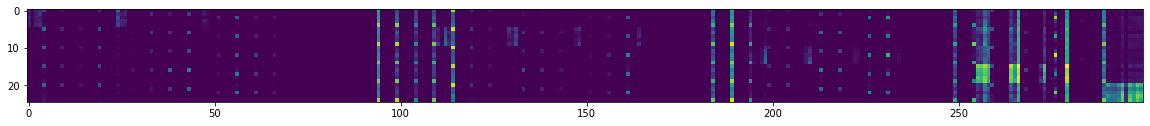

In [27]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

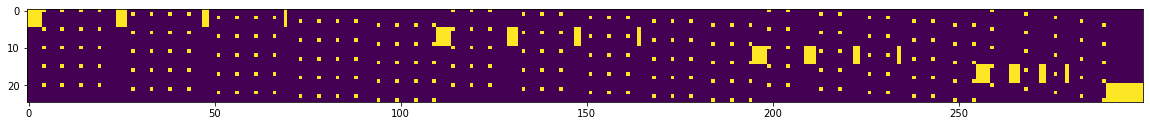

In [28]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

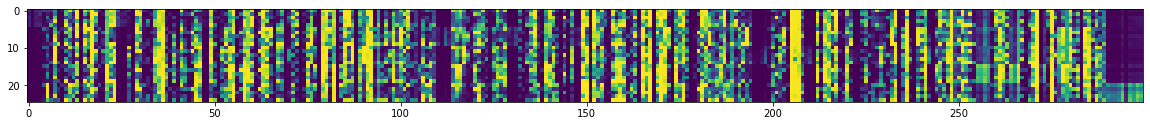

In [29]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

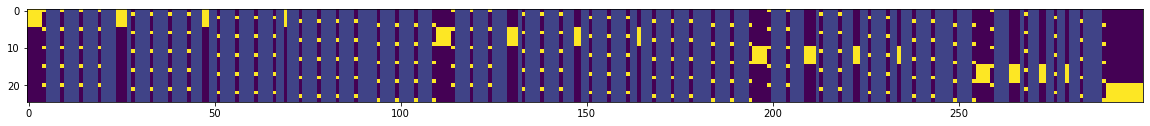

In [30]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

## Continue Training from checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '1g7i5ujc') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

In [ ]:
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=12000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

## Test after reloading checkpoint

In [24]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'epoch=3785-val_loss=417.28.ckpt') # best
run_PATH = os.path.join(project_name, '1g7i5ujc') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=300, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
#     callbacks=[checkpoint_callback]
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


In [25]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


query
 0 : 0 1 ('red', 'void') ('red', 'dashed')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted')]
query
 1 : 0 2 ('red', 'void') ('red', 'solid')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted')]
query
 2 : 0 3 ('red', 'void') ('red', 'checkered')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted')]
query
 3 : 0 4 ('red', 'void') ('red', 'dotted')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted')]
query
 4 : 0 5 ('red', 'void') ('green', 'void')
all matches 
 [('red', 'void'), ('green', 'void'), ('blue', 'void'), ('orange', 'void'), ('cyan', 'void')]
query
 5 : 0 6 ('red', 'void') ('green', 'dashed')
all matches 
 []
query
 6 : 0 7 ('red', 'void') ('green', 'solid')
all matches 
 []
query
 7 : 0 8 ('red', 'void') ('green', 'checkered')
all matches 
 []


 85 : 3 20 ('red', 'checkered') ('cyan', 'void')
all matches 
 []
query
 86 : 3 21 ('red', 'checkered') ('cyan', 'dashed')
all matches 
 []
query
 87 : 3 22 ('red', 'checkered') ('cyan', 'solid')
all matches 
 []
query
 88 : 3 23 ('red', 'checkered') ('cyan', 'checkered')
all matches 
 [('red', 'checkered'), ('green', 'checkered'), ('blue', 'checkered'), ('orange', 'checkered'), ('cyan', 'checkered')]
query
 89 : 3 24 ('red', 'checkered') ('cyan', 'dotted')
all matches 
 []
query
 90 : 4 5 ('red', 'dotted') ('green', 'void')
all matches 
 []
query
 91 : 4 6 ('red', 'dotted') ('green', 'dashed')
all matches 
 []
query
 92 : 4 7 ('red', 'dotted') ('green', 'solid')
all matches 
 []
query
 93 : 4 8 ('red', 'dotted') ('green', 'checkered')
all matches 
 []
query
 94 : 4 9 ('red', 'dotted') ('green', 'dotted')
all matches 
 [('red', 'dotted'), ('green', 'dotted'), ('blue', 'dotted'), ('orange', 'dotted'), ('cyan', 'dotted')]
query
 95 : 4 10 ('red', 'dotted') ('blue', 'void')
all matches 
 

 203 : 10 19 ('blue', 'void') ('orange', 'dotted')
all matches 
 []
query
 204 : 10 20 ('blue', 'void') ('cyan', 'void')
all matches 
 [('red', 'void'), ('green', 'void'), ('blue', 'void'), ('orange', 'void'), ('cyan', 'void')]
query
 205 : 10 21 ('blue', 'void') ('cyan', 'dashed')
all matches 
 []
query
 206 : 10 22 ('blue', 'void') ('cyan', 'solid')
all matches 
 []
query
 207 : 10 23 ('blue', 'void') ('cyan', 'checkered')
all matches 
 []
query
 208 : 10 24 ('blue', 'void') ('cyan', 'dotted')
all matches 
 []
query
 209 : 11 12 ('blue', 'dashed') ('blue', 'solid')
all matches 
 [('blue', 'void'), ('blue', 'dashed'), ('blue', 'solid'), ('blue', 'checkered'), ('blue', 'dotted')]
query
 210 : 11 13 ('blue', 'dashed') ('blue', 'checkered')
all matches 
 [('blue', 'void'), ('blue', 'dashed'), ('blue', 'solid'), ('blue', 'checkered'), ('blue', 'dotted')]
query
 211 : 11 14 ('blue', 'dashed') ('blue', 'dotted')
all matches 
 [('blue', 'void'), ('blue', 'dashed'), ('blue', 'solid'), ('blue'

Testing: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_NullQueries_accuracy_by_Query': 0.631525993347168,
 'avg_test_NullQueries_accuracy_by_QueryKey': 0.6315261125564575,
 'avg_test_NullQueries_error_rate_for_0_matched_concepts': 0.3684739679795859,
 'avg_test_NullQueries_error_rate_for_1_matched_concepts': 0.0,
 'avg_test_NullQueries_f1_by_Query': nan,
 'avg_test_NullQueries_f1_by_QueryKey': nan,
 'avg_test_NullQueries_precision_by_Query': 0.0,
 'avg_test_NullQueries_precision_by_QueryKey': 0.0,
 'avg_test_NullQueries_recall_by_Query': nan,
 'avg_test_NullQueries_recall_by_QueryKey': nan,
 'avg_test_NullQueries_total_count_for_0_matched_concepts': 1666.6666666666667,
 'avg_test_NullQueries_total_count_for_1_matched_concepts': 0.0,
 'avg_test_accuracy_by_Query': 0.7719696760177612,
 'avg_test_accuracy_by_QueryKey': 0.7719696760177612,
 'avg_test_error_rate_for_0_matche

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The testing_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


In [26]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

Sum of model logits matrix
 tensor(-15450.3984, device='cuda:1')
Number of model logits with zero value
 tensor(0, device='cuda:1')
Variance of model logits
 tensor(5.2952, device='cuda:1')
xy_hat_rank: 25
xy_div_xyind_hat_rank: 25
mi_hat: tensor(0.0647, device='cuda:1', dtype=torch.float64)
mi_gt_minus_hat: tensor(1.5447, device='cuda:1', dtype=torch.float64)
kl_div: tensor(0.0002, device='cuda:1', dtype=torch.float64)


/home/user/miniconda/lib/python3.8/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


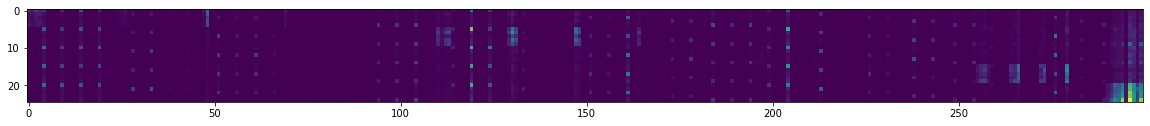

In [31]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

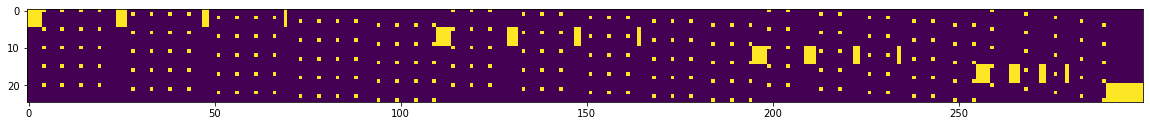

In [32]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

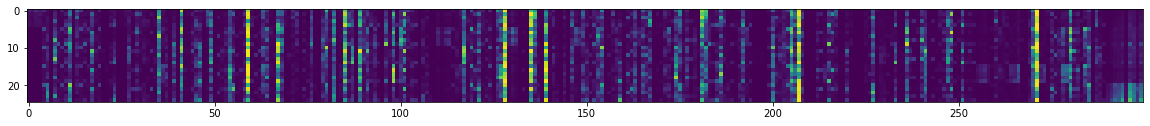

In [33]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

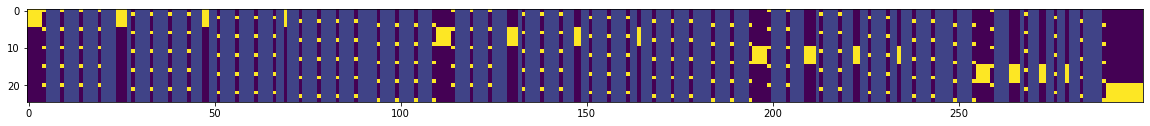

In [34]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])